<a href="https://colab.research.google.com/github/samrudhip006/REU_BRAIN_TUMOURS-CLASSIFICATION-AN-FUSION-OF-DIFFERENT-MODALITIES/blob/main/REU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
import os
import cv2
import numpy as np
from natsort import natsorted # To ensure sorting is natural (1, 2, ..., 10, 11)

# Define the base paths to your dataset folders
mri_path = '/content/drive/MyDrive/project data/sample dataset for Fusion/MRI/'
ct_path = '/content/drive/MyDrive/project data/sample dataset for Fusion/CT/'

# Get the list of all .jpg file names from both directories
mri_files = natsorted([f for f in os.listdir(mri_path) if f.endswith('.jpg')])
ct_files = natsorted([f for f in os.listdir(ct_path) if f.endswith('.jpg')])

# Create empty lists to store the loaded images
mri_images = []
ct_images = []

# Load MRI images
print("Loading MRI images...")
for file_name in mri_files:
    # Construct the full image path
    img_path = os.path.join(mri_path, file_name)
    # Read the image in grayscale
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        mri_images.append(image)
    else:
        print(f"Warning: Could not read MRI image: {img_path}")
print(f"Successfully loaded {len(mri_images)} MRI images.")


# Load CT images
print("\nLoading CT images...")
for file_name in ct_files:
    # Construct the full image path
    img_path = os.path.join(ct_path, file_name)
    # Read the image in grayscale
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        ct_images.append(image)
    else:
        print(f"Warning: Could not read CT image: {img_path}")
print(f"Successfully loaded {len(ct_images)} CT images.")

# For your convenience, you might want to convert the lists to NumPy arrays
mri_images = np.array(mri_images)
ct_images = np.array(ct_images)

Loading MRI images...
Successfully loaded 38 MRI images.

Loading CT images...
Successfully loaded 38 CT images.


Shape of the MRI images array: (38, 512, 512)
Shape of the CT images array: (38, 512, 512)


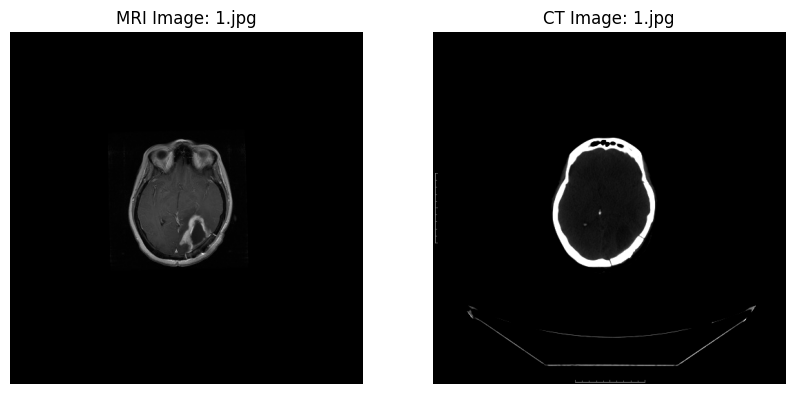

In [ ]:
import matplotlib.pyplot as plt

print(f"Shape of the MRI images array: {mri_images.shape}")
print(f"Shape of the CT images array: {ct_images.shape}")

# Check if there are images to display
if len(mri_images) > 0 and len(ct_images) > 0:
    # Display the first pair of images to verify
    plt.figure(figsize=(10, 5))

    # Plot the first MRI image
    plt.subplot(1, 2, 1)
    plt.imshow(mri_images[0], cmap='gray')
    plt.title(f'MRI Image: {mri_files[0]}')
    plt.axis('off')

    # Plot the first CT image
    plt.subplot(1, 2, 2)
    plt.imshow(ct_images[0], cmap='gray')
    plt.title(f'CT Image: {ct_files[0]}')
    plt.axis('off')

    plt.show()
else:
    print("No images were loaded to display.")

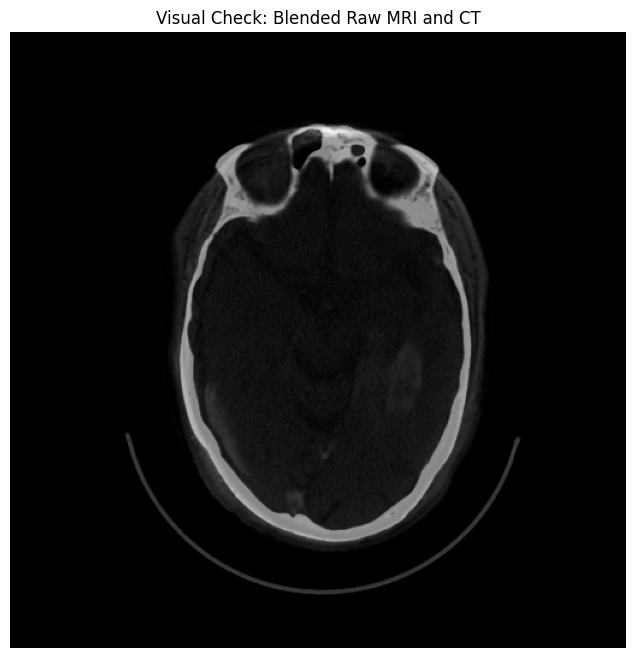

In [ ]:
# Code to visually check alignment
import matplotlib.pyplot as plt
import cv2

# Assuming mri_images and ct_images are loaded from the previous step
mri_to_check = mri_images[1]
ct_to_check = ct_images[1]

# Resize images to be the same dimension for blending (this is for VISUALIZATION only)
h, w = mri_to_check.shape
ct_resized = cv2.resize(ct_to_check, (w, h))

# Blend the two images
blended_image = cv2.addWeighted(src1=mri_to_check, alpha=0.5, src2=ct_resized, beta=0.5, gamma=0)

plt.figure(figsize=(8, 8))
plt.imshow(blended_image, cmap='gray')
plt.title('Visual Check: Blended Raw MRI and CT')
plt.axis('off')
plt.show()

In [ ]:
print("--- MRI Stats ---")
print(f"Min: {mri_to_check.min()}, Max: {mri_to_check.max()}, Mean: {mri_to_check.mean():.2f}")

print("\n--- CT Stats ---")
print(f"Min: {ct_to_check.min()}, Max: {ct_to_check.max()}, Mean: {ct_to_check.mean():.2f}")

--- MRI Stats ---
Min: 0, Max: 226, Mean: 19.54

--- CT Stats ---
Min: 0, Max: 255, Mean: 54.16


/usr/local/lib/python3.12/dist-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)


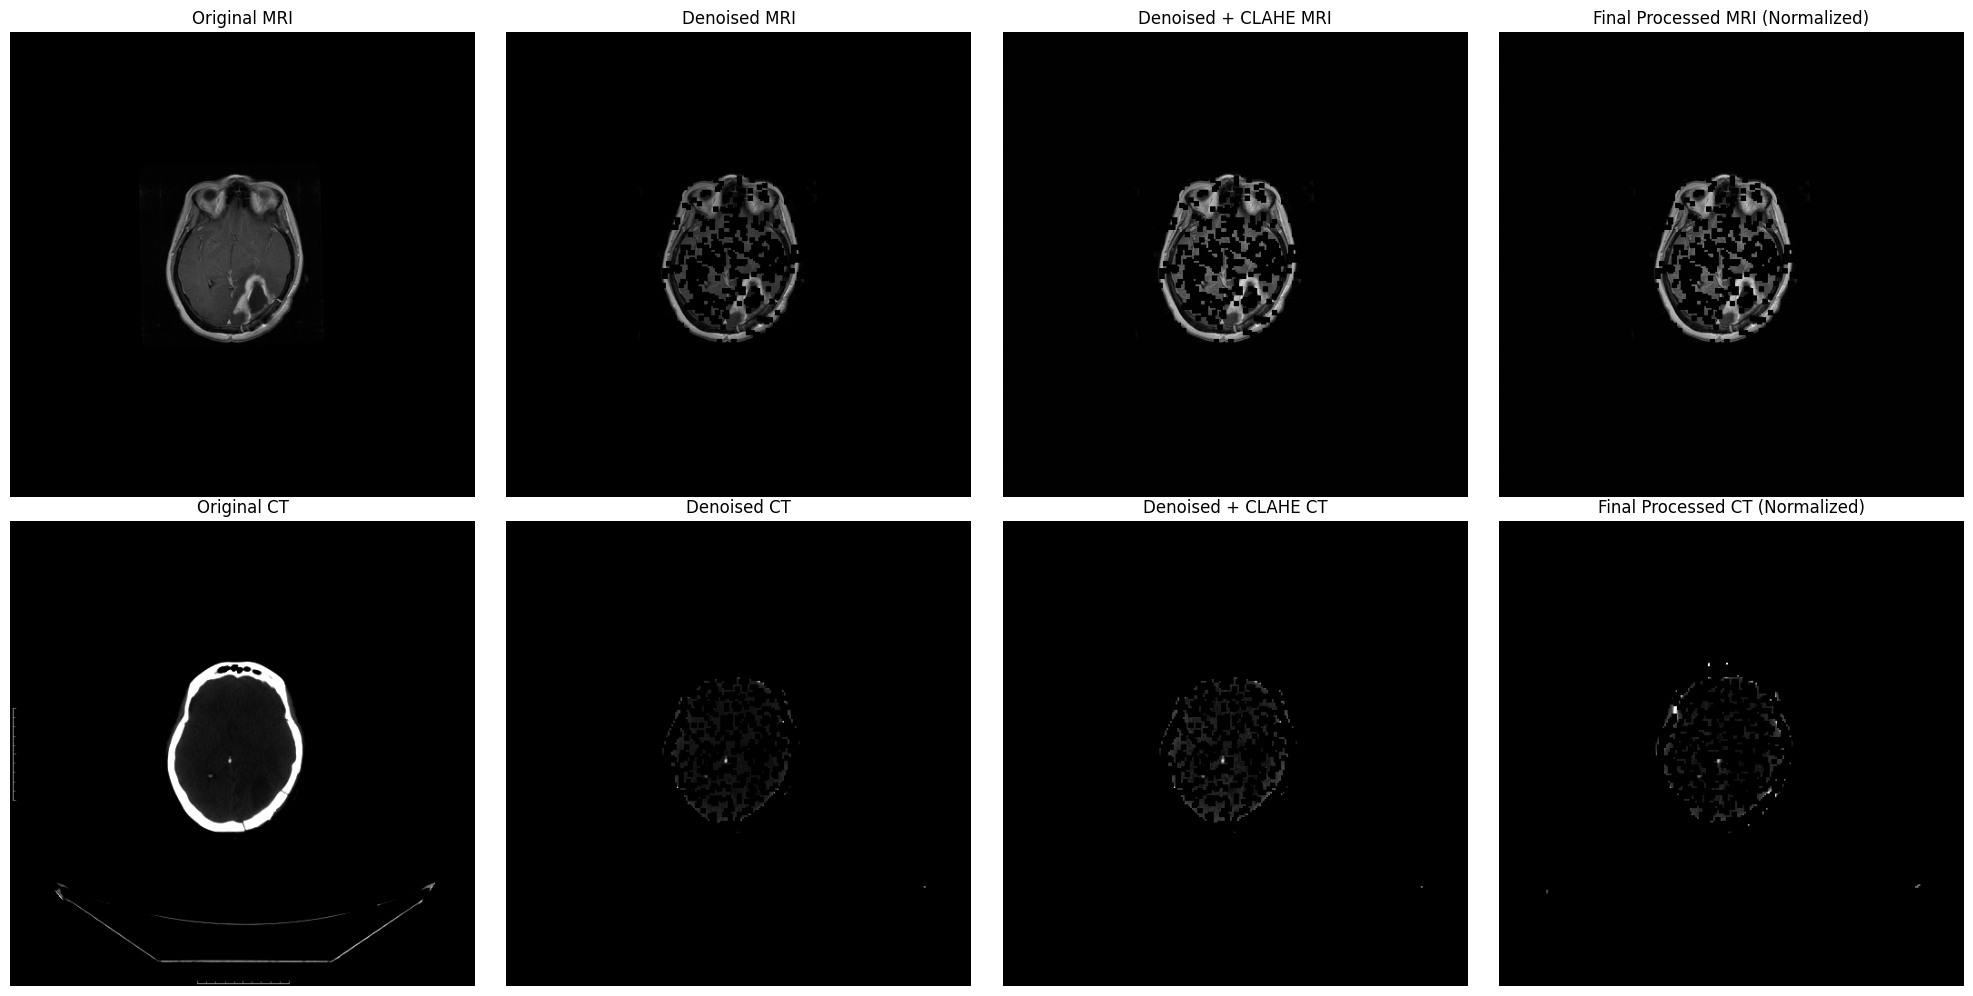

In [ ]:
import cv2
import numpy as np
import pywt

# --- INDIVIDUAL PREPROCESSING FUNCTIONS ---

def wavelet_denoising(image):
    # Convert to float for wavelet transform
    image = image.astype(np.float32)
    coeffs = pywt.dwt2(image, 'bior1.3') # Using a different wavelet
    cA, (cH, cV, cD) = coeffs

    # Calculate threshold
    sigma = np.median(np.abs(cD)) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(image.size))

    # Threshold coefficients
    coeffs_t = (
        cA,
        (pywt.threshold(cH, threshold, mode='soft'),
         pywt.threshold(cV, threshold, mode='soft'),
         pywt.threshold(cD, threshold, mode='soft'))
    )

    denoised_image = pywt.idwt2(coeffs_t, 'bior1.3')
    # Normalize back to 0-255 uint8 range
    denoised_image = cv2.normalize(denoised_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return denoised_image

def apply_clahe(image):
    # Image must be uint8
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return clahe_image

def zscore_normalize(image):
    # Convert to float for calculations
    image = image.astype(np.float32)
    mean = np.mean(image)
    std = np.std(image)
    if std == 0: # Avoid division by zero for blank images
        std = 1
    normalized_image = (image - mean) / std
    return normalized_image


# --- COMPLETE PREPROCESSING PIPELINE ---

def preprocess_image_pair(mri_image, ct_image):
    """
    Applies a full preprocessing pipeline to a pair of MRI and CT images.
    NOTE: Registration is a complex step and is simplified here.
    """
    # 1. Registration (Simplified for .jpg, MRI is fixed, CT is moving)
    # This is a placeholder for a more robust registration.
    # For a real thesis, you would use SimpleITK or ANTsPy.
    warp_mode = cv2.MOTION_TRANSLATION
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 1000, 1e-7)
    try:
        (cc, warp_matrix) = cv2.findTransformECC(mri_image, ct_image, warp_matrix, warp_mode, criteria)
        h, w = mri_image.shape
        registered_ct = cv2.warpAffine(ct_image, warp_matrix, (w, h), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    except cv2.error:
        print("Warning: Registration failed for an image pair. Using original CT.")
        registered_ct = ct_image


    # 2. Denoising
    denoised_mri = wavelet_denoising(mri_image)
    denoised_ct = wavelet_denoising(registered_ct)

    # 3. Contrast Enhancement (CLAHE)
    clahe_mri = apply_clahe(denoised_mri)
    clahe_ct = apply_clahe(denoised_ct)

    # 4. Normalization (Z-score)
    final_mri = zscore_normalize(clahe_mri)
    final_ct = zscore_normalize(clahe_ct)

    return final_mri, final_ct

# --- APPLY TO YOUR DATASET AND VISUALIZE ---

# Let's process the first pair of images
processed_mri, processed_ct = preprocess_image_pair(mri_images[0], ct_images[0])

# Visualize the results
plt.figure(figsize=(20, 10))

plt.subplot(2, 4, 1)
plt.imshow(mri_images[0], cmap='gray')
plt.title('Original MRI')
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(wavelet_denoising(mri_images[0]), cmap='gray')
plt.title('Denoised MRI')
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(apply_clahe(wavelet_denoising(mri_images[0])), cmap='gray')
plt.title('Denoised + CLAHE MRI')
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(processed_mri, cmap='gray')
plt.title('Final Processed MRI (Normalized)')
plt.axis('off')

plt.subplot(2, 4, 5)
plt.imshow(ct_images[0], cmap='gray')
plt.title('Original CT')
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(wavelet_denoising(ct_images[0]), cmap='gray')
plt.title('Denoised CT')
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(apply_clahe(wavelet_denoising(ct_images[0])), cmap='gray')
plt.title('Denoised + CLAHE CT')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(processed_ct, cmap='gray')
plt.title('Final Processed CT (Normalized)')
plt.axis('off')

plt.tight_layout()
plt.show()

--- Processing with Denoising ---

--- Processing without Denoising ---


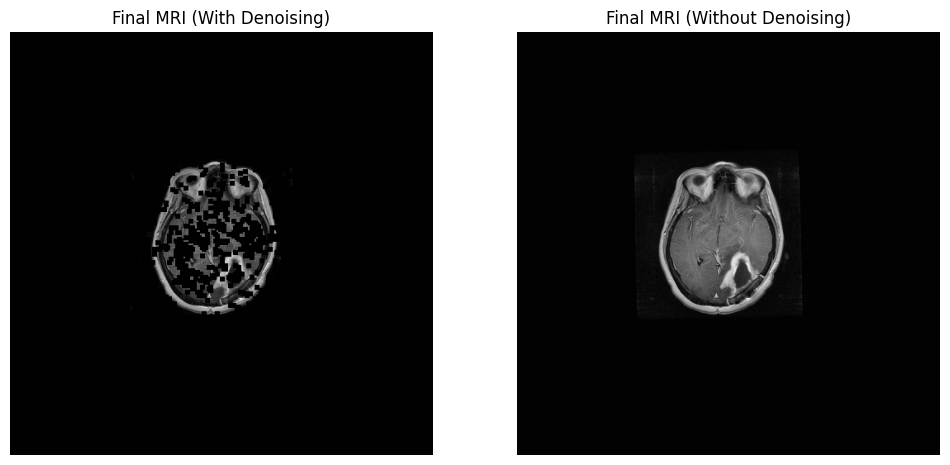

In [ ]:
# --- UPDATED PREPROCESSING PIPELINE ---

def preprocess_image_pair(mri_image, ct_image, denoise=False):
    """
    Applies a full preprocessing pipeline to a pair of MRI and CT images.
    The denoising step can be toggled on or off.
    """
    # 1. Registration (Simplified for .jpg)
    warp_mode = cv2.MOTION_TRANSLATION
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 1000, 1e-7)
    try:
        (cc, warp_matrix) = cv2.findTransformECC(mri_image, ct_image, warp_matrix, warp_mode, criteria)
        h, w = mri_image.shape
        registered_ct = cv2.warpAffine(ct_image, warp_matrix, (w, h), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    except cv2.error:
        print("Warning: Registration failed for an image pair. Using original CT.")
        registered_ct = ct_image

    # --- Toggled Denoising Step ---
    if denoise:
        # 2. Denoising
        processed_mri = wavelet_denoising(mri_image)
        processed_ct = wavelet_denoising(registered_ct)
    else:
        # If not denoising, use the original/registered images directly
        processed_mri = mri_image
        processed_ct = registered_ct
    # -----------------------------

    # 3. Contrast Enhancement (CLAHE)
    # Ensure images are uint8 before CLAHE
    clahe_mri = apply_clahe(processed_mri.astype(np.uint8))
    clahe_ct = apply_clahe(processed_ct.astype(np.uint8))

    # 4. Normalization (Z-score)
    final_mri = zscore_normalize(clahe_mri)
    final_ct = zscore_normalize(clahe_ct)

    return final_mri, final_ct

# --- HOW TO USE IT FOR YOUR EXPERIMENTS ---

# Experiment 1: WITH denoising
print("--- Processing with Denoising ---")
processed_mri_denoised, processed_ct_denoised = preprocess_image_pair(mri_images[0], ct_images[0], denoise=True)

# Experiment 2: WITHOUT denoising
print("\n--- Processing without Denoising ---")
processed_mri_no_denoise, processed_ct_no_denoise = preprocess_image_pair(mri_images[0], ct_images[0], denoise=False)


# --- VISUALIZE THE DIFFERENCE ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(processed_mri_denoised, cmap='gray')
plt.title('Final MRI (With Denoising)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_mri_no_denoise, cmap='gray')
plt.title('Final MRI (Without Denoising)')
plt.axis('off')

plt.show()

In [ ]:
import os

# Define paths for the new directories where processed images will be saved
processed_mri_path = '/content/drive/MyDrive/project data/sample dataset for Fusion/MRI_preprocessed/'
processed_ct_path = '/content/drive/MyDrive/project data/sample dataset for Fusion/CT_preprocessed/'

# Create the directories if they don't already exist
os.makedirs(processed_mri_path, exist_ok=True)
os.makedirs(processed_ct_path, exist_ok=True)

print(f"Directory created or already exists: {processed_mri_path}")
print(f"Directory created or already exists: {processed_ct_path}")

main preprocoessing and saving

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm # A library to show a nice progress bar

# --- 1. Define Input and Output Paths ---

# Input paths (where your raw .jpg images are)
mri_input_path = '/content/drive/MyDrive/project data/sample dataset for Fusion/MRI/'
ct_input_path = '/content/drive/MyDrive/project data/sample dataset for Fusion/CT/'

# Output paths (where we will save the processed .npy files)
mri_output_path = '/content/drive/MyDrive/project data/sample dataset for Fusion/Processed_MRI_noDenoise/'
ct_output_path = '/content/drive/MyDrive/project data/sample dataset for Fusion/Processed_CT_noDenoise/'

# Create the output directories if they don't exist
os.makedirs(mri_output_path, exist_ok=True)
os.makedirs(ct_output_path, exist_ok=True)


# --- 2. Copy Helper Functions from Before ---

def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # Ensure image is uint8 for CLAHE
    clahe_image = clahe.apply(image.astype(np.uint8))
    return clahe_image

def zscore_normalize(image):
    image = image.astype(np.float32)
    mean = np.mean(image)
    std = np.std(image)
    if std == 0:
        std = 1
    normalized_image = (image - mean) / std
    return normalized_image

def preprocess_image_pair_for_saving(mri_image, ct_image):
    """
    Preprocessing pipeline WITHOUT denoising.
    """
    # 1. Registration
    warp_mode = cv2.MOTION_TRANSLATION
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 1000, 1e-7)
    try:
        (cc, warp_matrix) = cv2.findTransformECC(mri_image, ct_image, warp_matrix, warp_mode, criteria)
        h, w = mri_image.shape
        registered_ct = cv2.warpAffine(ct_image, warp_matrix, (w, h), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    except cv2.error:
        registered_ct = ct_image

    # Denoising step is SKIPPED

    # 2. Contrast Enhancement (CLAHE)
    clahe_mri = apply_clahe(mri_image)
    clahe_ct = apply_clahe(registered_ct)

    # 3. Normalization (Z-score)
    final_mri = zscore_normalize(clahe_mri)
    final_ct = zscore_normalize(clahe_ct)

    return final_mri, final_ct


# --- 3. Loop, Process, and Save the Entire Dataset ---

# Ensure you have the file lists from the initial data loading step
# If not, uncomment the line below:
# mri_files = natsorted([f for f in os.listdir(mri_input_path) if f.endswith('.jpg')])

print("Starting preprocessing and saving process...")

# Use tqdm for a progress bar
for file_name in tqdm(mri_files, desc="Processing Images"):
    # Define full paths for input images
    mri_img_path = os.path.join(mri_input_path, file_name)
    ct_img_path = os.path.join(ct_input_path, file_name) # Assumes file names are identical

    # Load the raw images
    raw_mri = cv2.imread(mri_img_path, cv2.IMREAD_GRAYSCALE)
    raw_ct = cv2.imread(ct_img_path, cv2.IMREAD_GRAYSCALE)

    if raw_mri is not None and raw_ct is not None:
        # Process the image pair
        processed_mri, processed_ct = preprocess_image_pair_for_saving(raw_mri, raw_ct)

        # Define the output file paths, changing the extension from .jpg to .npy
        base_name = os.path.splitext(file_name)[0]
        mri_save_path = os.path.join(mri_output_path, f"{base_name}.npy")
        ct_save_path = os.path.join(ct_output_path, f"{base_name}.npy")

        # Save the processed numpy arrays
        np.save(mri_save_path, processed_mri)
        np.save(ct_save_path, processed_ct)

print("\nPreprocessing complete!")
print(f"Saved processed MRI images to: {mri_output_path}")
print(f"Saved processed CT images to: {ct_output_path}")

Starting preprocessing and saving process...


Processing Images: 100%|██████████| 38/38 [00:43<00:00,  1.15s/it]


Preprocessing complete!
Saved processed MRI images to: /content/drive/MyDrive/project data/sample dataset for Fusion/Processed_MRI_noDenoise/
Saved processed CT images to: /content/drive/MyDrive/project data/sample dataset for Fusion/Processed_CT_noDenoise/


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from skimage import exposure # For CLAHE
import torch
import torchvision.models as models
from torchvision import transforms

In [ ]:
!pip install timm scikit-image pywavelets

guided_filter_fusion class

In [ ]:
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter

def guided_filter_fusion_advanced(ct_image, mri_image, radius=60, eps=1e-3):
    """
    An advanced fusion method using saliency-based weight maps.
    """
    print("--- Starting Advanced Guided Filter Fusion ---")

    # 1. Decomposition
    base_ct = cv2.ximgproc.guidedFilter(guide=ct_image, src=ct_image, radius=radius, eps=eps)
    detail_ct = ct_image - base_ct

    base_mri = cv2.ximgproc.guidedFilter(guide=mri_image, src=mri_image, radius=radius, eps=eps)
    detail_mri = mri_image - base_mri

    # 2. Saliency Map Generation
    saliency_ct = gaussian_filter(detail_ct**2, sigma=3)
    saliency_mri = gaussian_filter(detail_mri**2, sigma=3)

    # 3. Weight Map Normalization
    total_saliency = saliency_ct + saliency_mri + 1e-12 # Epsilon for stability
    weight_ct = saliency_ct / total_saliency
    weight_mri = saliency_mri / total_saliency

    # 4. Fusion using the calculated Weight Maps
    fused_image = (weight_ct * ct_image) + (weight_mri * mri_image)

    print("--- Fusion Complete ---")
    return fused_image, weight_ct, weight_mri

feature extrator

In [ ]:
import torch
import timm
from torchvision import transforms
import numpy as np
import cv2
from skimage.feature import hog, graycomatrix, graycoprops, local_binary_pattern
import pywt
import os

# --- Part A: Deep Feature Extractor ---

# Load models once to avoid reloading them repeatedly
# Using lightweight versions as requested
MODELS = {
    'resnet18': timm.create_model('resnet18', pretrained=True, num_classes=0).eval(),
    'efficientnet_b0': timm.create_model('efficientnet_b0', pretrained=True, num_classes=0).eval(),
    'vit_b_16': timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0).eval()
}
# Move models to GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
for model_name in MODELS:
    MODELS[model_name].to(DEVICE)

def extract_deep_features(image_array, model_name):
    """
    Extracts features from a single image using a specified pre-trained model.

    Args:
        image_array (np.array): Preprocessed image (float, Z-scored).
        model_name (str): Name of the model ('resnet18', 'efficientnet_b0', 'vit_b_16').

    Returns:
        np.array: Flattened feature vector.
    """
    if model_name not in MODELS:
        raise ValueError(f"Model {model_name} not available.")

    model = MODELS[model_name]

    # Standard transformations for ImageNet-pretrained models
    transform = transforms.Compose([
        transforms.ToTensor(),
        # Repeat single channel to 3 channels
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Apply transformations
    image_tensor = transform(image_array.astype(np.float32)).unsqueeze(0).to(DEVICE)

    # Extract features
    with torch.no_grad():
        features = model(image_tensor)

    return features.cpu().numpy().flatten()


# --- Part B: Handcrafted Feature Extractor ---

def extract_handcrafted_features(image_array_uint8):
    """
    Extracts a suite of handcrafted features from a single 8-bit image.

    Args:
        image_array_uint8 (np.array): Image in uint8 format (0-255).

    Returns:
        np.array: Concatenated vector of all handcrafted features.
    """
    # 1. HOG Features
    hog_feats = hog(image_array_uint8, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=False, feature_vector=True)

    # 2. LBP Features
    lbp = local_binary_pattern(image_array_uint8, P=8, R=1, method='uniform')
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6) # Normalize histogram

    # 3. GLCM Features
    glcm = graycomatrix(image_array_uint8, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    glcm_props = [graycoprops(glcm, prop).ravel()[0] for prop in
                  ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']]

    # 4. DWT Features
    coeffs2 = pywt.dwt2(image_array_uint8, 'bior1.3')
    LL, (LH, HL, HH) = coeffs2
    dwt_features = np.array([
        LL.mean(), LL.std(), # Approximation
        LH.mean(), LH.std(), # Horizontal detail
        HL.mean(), HL.std(), # Vertical detail
        HH.mean(), HH.std()  # Diagonal detail
    ])

    # Concatenate all handcrafted features
    return np.hstack([hog_feats, lbp_hist, glcm_props, dwt_features])


# --- Part C: Master Ensemble Feature Extractor ---

def extract_feature_ensemble(image_array):
    """
    Runs the full feature extraction pipeline on a single preprocessed image.

    Args:
        image_array (np.array): Preprocessed image (float, Z-scored).

    Returns:
        np.array: The final, concatenated feature vector from all extractors.
    """
    print(f"--- Starting Ensemble Feature Extraction ---")

    # --- Deep Features ---
    # These models expect float inputs, which we already have
    print("Extracting ResNet18 features...")
    features_resnet = extract_deep_features(image_array, 'resnet18')
    print(f"  > Shape: {features_resnet.shape}")

    print("Extracting EfficientNet-B0 features...")
    features_effnet = extract_deep_features(image_array, 'efficientnet_b0')
    print(f"  > Shape: {features_effnet.shape}")

    print("Extracting ViT-B/16 features...")
    features_vit = extract_deep_features(image_array, 'vit_b_16')
    print(f"  > Shape: {features_vit.shape}")

    # --- Handcrafted Features ---
    # These models need a uint8 image, so we convert our normalized float image
    print("Extracting Handcrafted features...")
    image_uint8 = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    features_handcrafted = extract_handcrafted_features(image_uint8)
    print(f"  > Shape: {features_handcrafted.shape}")

    # --- Concatenate All Features ---
    final_features = np.concatenate([
        features_resnet,
        features_effnet,
        features_vit,
        features_handcrafted
    ])
    print(f"--- Final Combined Feature Vector Shape: {final_features.shape} ---")

    return final_features

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

pipeline early fusion

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 1.npy
Loading MRI from: 1.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =

Final Early Fusion Feature Vector Shape: (10774,)


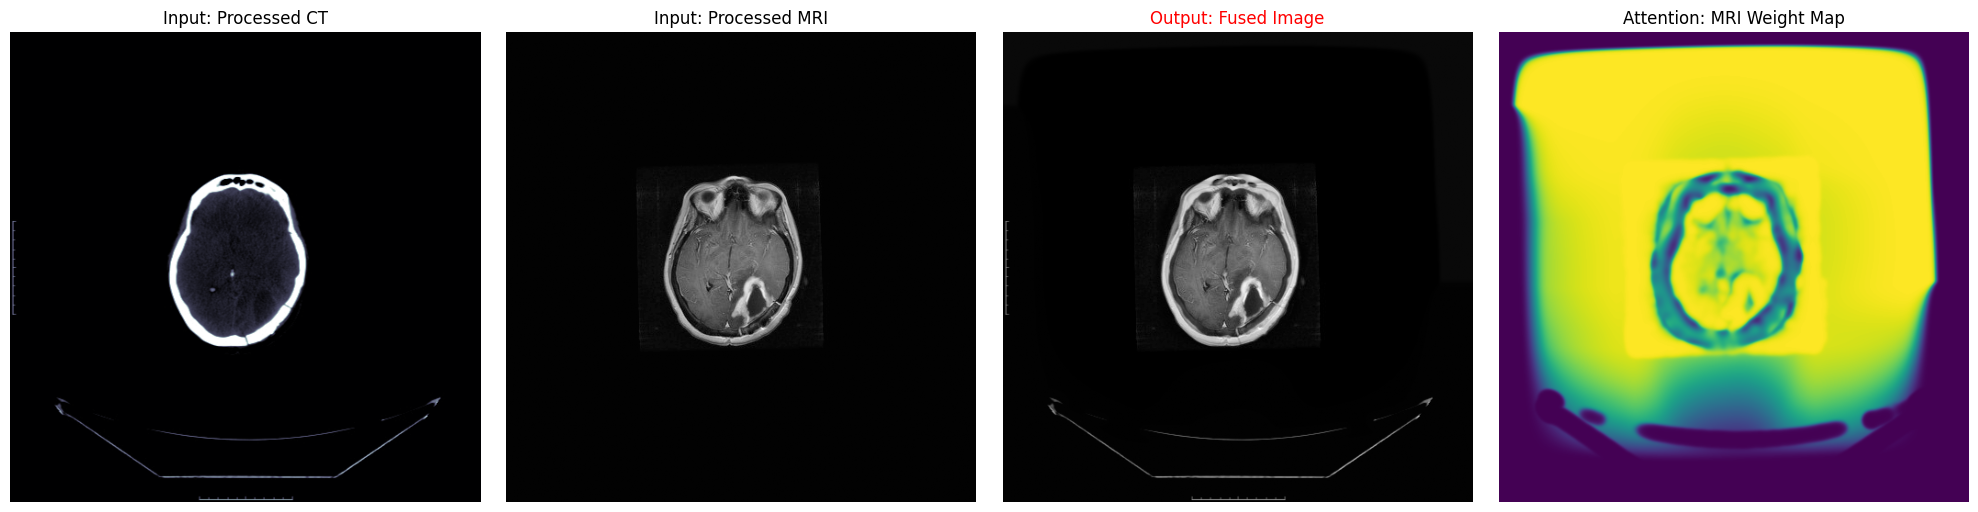

In [ ]:
import os
import matplotlib.pyplot as plt

# --- Ensure you have the feature extraction functions from the previous step here ---
# (I am assuming extract_feature_ensemble and its helpers are in your notebook)

# --- Your data paths ---
MRI_PROCESSED_DIR = '/content/drive/MyDrive/project data/sample dataset for Fusion/Processed_MRI_noDenoise/'
CT_PROCESSED_DIR = '/content/drive/MyDrive/project data/sample dataset for Fusion/Processed_CT_noDenoise/'

def load_processed_npy(path):
    """Loads a preprocessed image from a .npy file."""
    image_array = np.load(path)
    if image_array.dtype != np.float32:
        image_array = image_array.astype(np.float32)
    return image_array

def run_early_fusion_pipeline(ct_npy_path, mri_npy_path):
    """
    Executes the complete early fusion pipeline for a single pair of images.

    1. Loads preprocessed CT and MRI images.
    2. Fuses them using the advanced guided filter method.
    3. Extracts the full ensemble of features from the single fused image.

    Returns:
        np.array: The final feature vector.
        np.array: The intermediate fused image for visualization.
    """
    print("=============================================")
    print("=      STARTING EARLY FUSION PIPELINE       =")
    print("=============================================")

    # Step 1: Load preprocessed images
    print(f"Loading CT from: {os.path.basename(ct_npy_path)}")
    print(f"Loading MRI from: {os.path.basename(mri_npy_path)}")
    ct_processed = load_processed_npy(ct_npy_path)
    mri_processed = load_processed_npy(mri_npy_path)

    # Step 2: Fuse the images to create a single new image
    fused_image, weight_ct, weight_mri = guided_filter_fusion_advanced(ct_processed, mri_processed)

    # Step 3: Extract the feature ensemble from the FUSED image
    # The extract_feature_ensemble function will print its own progress
    final_features = extract_feature_ensemble(fused_image)

    print("\n=============================================")
    print("=       EARLY FUSION PIPELINE COMPLETE      =")
    print("=============================================")

    return final_features, fused_image, weight_ct, weight_mri


# --- Example Usage: Run the pipeline on the first pair of images ---
try:
    ct_files = sorted(os.listdir(CT_PROCESSED_DIR))
    mri_files = sorted(os.listdir(MRI_PROCESSED_DIR))

    if not ct_files or not mri_files:
        print("Error: Processed directories are empty.")
    else:
        # Define paths for the first pair
        CT_NPY_PATH = os.path.join(CT_PROCESSED_DIR, ct_files[0])
        MRI_NPY_PATH = os.path.join(MRI_PROCESSED_DIR, mri_files[0])

        # Run the entire pipeline
        early_fusion_features, final_fused_image, w_ct, w_mri = run_early_fusion_pipeline(CT_NPY_PATH, MRI_NPY_PATH)

        print(f"\nFinal Early Fusion Feature Vector Shape: {early_fusion_features.shape}")

        # --- Visualize the results ---
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        axes[0].imshow(load_processed_npy(CT_NPY_PATH), cmap='bone')
        axes[0].set_title('Input: Processed CT')

        axes[1].imshow(load_processed_npy(MRI_NPY_PATH), cmap='gray')
        axes[1].set_title('Input: Processed MRI')

        axes[2].imshow(final_fused_image, cmap='gray')
        axes[2].set_title('Output: Fused Image', color='red')

        # Show one of the weight maps to visualize the "attention"
        axes[3].imshow(w_mri, cmap='viridis')
        axes[3].set_title('Attention: MRI Weight Map')

        for ax in axes:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

except (FileNotFoundError, IndexError) as e:
    print(f"\nAn error occurred. Please check your file paths and ensure the directories exist and are not empty.")
    print(e)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import os
import matplotlib.pyplot as plt

# --- Ensure you have the feature extraction functions from the previous steps ---
# (I am assuming extract_feature_ensemble and its helpers are in your notebook)

# --- Your data paths ---
MRI_PROCESSED_DIR = '/content/drive/MyDrive/project data/sample dataset for Fusion/Processed_MRI_noDenoise/'
CT_PROCESSED_DIR = '/content/drive/MyDrive/project data/sample dataset for Fusion/Processed_CT_noDenoise/'

def load_processed_npy(path):
    """Loads a preprocessed image from a .npy file."""
    image_array = np.load(path)
    if image_array.dtype != np.float32:
        image_array = image_array.astype(np.float32)
    return image_array

# --- Strategy 1: Baseline Late Fusion (Concatenation) ---

def run_late_fusion_pipeline_baseline(ct_npy_path, mri_npy_path):
    """
    Executes the baseline late fusion pipeline for a single pair of images.

    1. Extracts feature ensemble from the CT image.
    2. Extracts feature ensemble from the MRI image.
    3. Fuses the two feature vectors by concatenating them.

    Returns:
        np.array: The final, concatenated feature vector.
    """
    print("=============================================")
    print("=  STARTING LATE FUSION PIPELINE (BASELINE) =")
    print("=============================================")

    # Step 1: CT Feature Extraction Stream
    print("\n--- Processing CT Stream ---")
    ct_processed = load_processed_npy(ct_npy_path)
    features_ct = extract_feature_ensemble(ct_processed)

    # Step 2: MRI Feature Extraction Stream
    print("\n--- Processing MRI Stream ---")
    mri_processed = load_processed_npy(mri_npy_path)
    features_mri = extract_feature_ensemble(mri_processed)

    # Step 3: Fuse features by concatenation
    print("\n--- Fusing features via Concatenation ---")
    combined_features = np.concatenate((features_ct, features_mri), axis=0)

    print("\n=============================================")
    print("=     LATE FUSION (BASELINE) COMPLETE       =")
    print("=============================================")

    return combined_features


# --- Strategy 2: Advanced Late Fusion (Attention Mechanism) ---

class AttentionFusion(nn.Module):
    """
    A small neural network to learn attention weights for fusing two feature vectors.
    """
    def __init__(self, input_dim):
        super(AttentionFusion, self).__init__()
        # This network takes the concatenated features and outputs two attention scores
        self.attention_net = nn.Sequential(
            nn.Linear(input_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, features_ct, features_mri):
        # Concatenate features to feed into the attention network
        concatenated_features = torch.cat((features_ct, features_mri), dim=1)

        # Get the attention weights (e.g., [[0.4, 0.6]])
        attention_weights = self.attention_net(concatenated_features)

        # Separate the weights for each modality
        weight_ct = attention_weights[:, 0].unsqueeze(1)
        weight_mri = attention_weights[:, 1].unsqueeze(1)

        # Apply the weights to the original feature vectors and sum them up
        fused_features = (weight_ct * features_ct) + (weight_mri * features_mri)
        return fused_features, attention_weights

def run_late_fusion_pipeline_advanced(ct_npy_path, mri_npy_path, attention_model):
    """
    Executes the advanced late fusion pipeline for a single pair of images.
    NOTE: This requires a trained 'attention_model'. For this demo, we use an untrained one.
    """
    print("=============================================")
    print("= STARTING LATE FUSION PIPELINE (ADVANCED)  =")
    print("=============================================")

    # Step 1 & 2: Extract features for CT and MRI (same as baseline)
    ct_processed = load_processed_npy(ct_npy_path)
    features_ct = extract_feature_ensemble(ct_processed)

    mri_processed = load_processed_npy(mri_npy_path)
    features_mri = extract_feature_ensemble(mri_processed)

    # Step 3: Fuse features using the attention model
    print("\n--- Fusing features via Attention Mechanism ---")

    # Convert numpy arrays to PyTorch tensors
    # Add a batch dimension (batch size of 1)
    features_ct_tensor = torch.from_numpy(features_ct).unsqueeze(0).to(DEVICE)
    features_mri_tensor = torch.from_numpy(features_mri).unsqueeze(0).to(DEVICE)

    # Pass features through the attention model
    attention_model.eval() # Set to evaluation mode
    with torch.no_grad():
        fused_features_tensor, weights_tensor = attention_model(features_ct_tensor, features_mri_tensor)

    print("\n=============================================")
    print("=    LATE FUSION (ADVANCED) COMPLETE        =")
    print("=============================================")

    # Return numpy arrays for consistency
    return fused_features_tensor.cpu().numpy().flatten(), weights_tensor.cpu().numpy().flatten()

In [ ]:
try:
    ct_files = sorted(os.listdir(CT_PROCESSED_DIR))
    mri_files = sorted(os.listdir(MRI_PROCESSED_DIR))

    if not ct_files or not mri_files:
        print("Error: Processed directories are empty.")
    else:
        # Define paths for the first pair
        CT_NPY_PATH = os.path.join(CT_PROCESSED_DIR, ct_files[0])
        MRI_NPY_PATH = os.path.join(MRI_PROCESSED_DIR, mri_files[0])

        # --- Run Baseline Pipeline ---
        late_fusion_features_baseline = run_late_fusion_pipeline_baseline(CT_NPY_PATH, MRI_NPY_PATH)
        print(f"\nFinal Late Fusion (Baseline) Feature Vector Shape: {late_fusion_features_baseline.shape}")

        print("\n" + "="*50 + "\n") # Separator

        # --- Run Advanced Pipeline ---

        # First, we need to know the size of a single feature vector to initialize the model
        # Let's get it from the baseline run
        single_feature_dim = len(late_fusion_features_baseline) // 2

        # Initialize the attention model
        # In a real scenario, this model would be loaded with trained weights.
        # Here, we are just demonstrating the data flow.
        attention_model = AttentionFusion(input_dim=single_feature_dim).to(DEVICE)

        late_fusion_features_advanced, attention_weights = run_late_fusion_pipeline_advanced(
            CT_NPY_PATH, MRI_NPY_PATH, attention_model
        )

        print(f"\nFinal Late Fusion (Advanced) Feature Vector Shape: {late_fusion_features_advanced.shape}")
        print(f"Learned Attention Weights (CT, MRI): {attention_weights}")

except (FileNotFoundError, IndexError) as e:
    print(f"\nAn error occurred. Please check your file paths.")
    print(e)

=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =

Final Late Fusion (Baseline) Feature Vector Shape: (21548,)


= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 feature

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# --- (The AttentionFusion class definition remains the same) ---
class AttentionFusion(nn.Module):
    """
    A small neural network to learn attention weights for fusing two feature vectors.
    """
    def __init__(self, input_dim):
        super(AttentionFusion, self).__init__()
        self.attention_net = nn.Sequential(
            nn.Linear(input_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, features_ct, features_mri):
        concatenated_features = torch.cat((features_ct, features_mri), dim=1)
        attention_weights = self.attention_net(concatenated_features)
        weight_ct = attention_weights[:, 0].unsqueeze(1)
        weight_mri = attention_weights[:, 1].unsqueeze(1)
        fused_features = (weight_ct * features_ct) + (weight_mri * features_mri)
        return fused_features, attention_weights

# --- CORRECTED FUNCTION ---
def run_late_fusion_pipeline_advanced(ct_npy_path, mri_npy_path, attention_model):
    """
    Executes the advanced late fusion pipeline for a single pair of images.
    NOTE: This requires a trained 'attention_model'. For this demo, we use an untrained one.
    """
    print("=============================================")
    print("= STARTING LATE FUSION PIPELINE (ADVANCED)  =")
    print("=============================================")

    # Step 1 & 2: Extract features for CT and MRI
    ct_processed = load_processed_npy(ct_npy_path)
    features_ct = extract_feature_ensemble(ct_processed)

    mri_processed = load_processed_npy(mri_npy_path)
    features_mri = extract_feature_ensemble(mri_processed)

    # Step 3: Fuse features using the attention model
    print("\n--- Fusing features via Attention Mechanism ---")

    # Convert numpy arrays to PyTorch tensors
    # Add a batch dimension and ensure dtype is float32
    features_ct_tensor = torch.from_numpy(features_ct).unsqueeze(0).float().to(DEVICE) # <-- FIX
    features_mri_tensor = torch.from_numpy(features_mri).unsqueeze(0).float().to(DEVICE) # <-- FIX

    # Pass features through the attention model
    attention_model.eval()
    with torch.no_grad():
        fused_features_tensor, weights_tensor = attention_model(features_ct_tensor, features_mri_tensor)

    print("\n=============================================")
    print("=    LATE FUSION (ADVANCED) COMPLETE        =")
    print("=============================================")

    # Return numpy arrays for consistency
    return fused_features_tensor.cpu().numpy().flatten(), weights_tensor.cpu().numpy().flatten()

In [ ]:
try:
    ct_files = sorted(os.listdir(CT_PROCESSED_DIR))
    mri_files = sorted(os.listdir(MRI_PROCESSED_DIR))

    if not ct_files or not mri_files:
        print("Error: Processed directories are empty.")
    else:
        # Define paths for the first pair
        CT_NPY_PATH = os.path.join(CT_PROCESSED_DIR, ct_files[0])
        MRI_NPY_PATH = os.path.join(MRI_PROCESSED_DIR, mri_files[0])

        # --- Run Baseline Pipeline ---
        late_fusion_features_baseline = run_late_fusion_pipeline_baseline(CT_NPY_PATH, MRI_NPY_PATH)
        print(f"\nFinal Late Fusion (Baseline) Feature Vector Shape: {late_fusion_features_baseline.shape}")

        print("\n" + "="*50 + "\n") # Separator

        # --- Run Advanced Pipeline ---

        # First, we need to know the size of a single feature vector to initialize the model
        # Let's get it from the baseline run
        single_feature_dim = len(late_fusion_features_baseline) // 2

        # Initialize the attention model
        # In a real scenario, this model would be loaded with trained weights.
        # Here, we are just demonstrating the data flow.
        attention_model = AttentionFusion(input_dim=single_feature_dim).to(DEVICE)

        late_fusion_features_advanced, attention_weights = run_late_fusion_pipeline_advanced(
            CT_NPY_PATH, MRI_NPY_PATH, attention_model
        )

        print(f"\nFinal Late Fusion (Advanced) Feature Vector Shape: {late_fusion_features_advanced.shape}")
        print(f"Learned Attention Weights (CT, MRI): {attention_weights}")

except (FileNotFoundError, IndexError) as e:
    print(f"\nAn error occurred. Please check your file paths.")
    print(e)

=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =

Final Late Fusion (Baseline) Feature Vector Shape: (21548,)


= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 feature

In [ ]:
import os
import numpy as np
from tqdm import tqdm # For a nice progress bar

# --- 1. Define Paths for Saving Features ---
EARLY_FUSION_FEATURES_DIR = '/content/drive/MyDrive/project data/sample dataset for Fusion/Features_EarlyFusion/'
LATE_FUSION_BASELINE_FEATURES_DIR = '/content/drive/MyDrive/project data/sample dataset for Fusion/Features_LateFusion_Baseline/'
LATE_FUSION_ADVANCED_FEATURES_DIR = '/content/drive/MyDrive/project data/sample dataset for Fusion/Features_LateFusion_Advanced/'

# Create directories if they don't exist
os.makedirs(EARLY_FUSION_FEATURES_DIR, exist_ok=True)
os.makedirs(LATE_FUSION_BASELINE_FEATURES_DIR, exist_ok=True)
os.makedirs(LATE_FUSION_ADVANCED_FEATURES_DIR, exist_ok=True)

# --- 2. Get the list of processed files ---
# (Assuming your processed files are named identically, e.g., '1.npy', '2.npy')
processed_files = sorted(os.listdir(CT_PROCESSED_DIR))

# --- 3. Process and Save Features for All Pipelines ---

# --- Early Fusion ---
print("--- Generating and Saving Early Fusion Features ---")
for file_name in tqdm(processed_files, desc="Early Fusion"):
    base_name = os.path.splitext(file_name)[0]
    ct_path = os.path.join(CT_PROCESSED_DIR, file_name)
    mri_path = os.path.join(MRI_PROCESSED_DIR, file_name)

    # Run the pipeline (we only need the feature vector here)
    early_features, _, _, _ = run_early_fusion_pipeline(ct_path, mri_path)

    # Save the feature vector
    save_path = os.path.join(EARLY_FUSION_FEATURES_DIR, f"{base_name}.npy")
    np.save(save_path, early_features)

# --- Late Fusion (Baseline) ---
print("\n--- Generating and Saving Late Fusion (Baseline) Features ---")
for file_name in tqdm(processed_files, desc="Late Fusion (Baseline)"):
    base_name = os.path.splitext(file_name)[0]
    ct_path = os.path.join(CT_PROCESSED_DIR, file_name)
    mri_path = os.path.join(MRI_PROCESSED_DIR, file_name)

    late_features_baseline = run_late_fusion_pipeline_baseline(ct_path, mri_path)
    save_path = os.path.join(LATE_FUSION_BASELINE_FEATURES_DIR, f"{base_name}.npy")
    np.save(save_path, late_features_baseline)

# --- Late Fusion (Advanced) ---
# NOTE: This requires the AttentionFusion model. As it's untrained, the features are
# for demonstrating the workflow. You'll re-run this part later within a training loop.
print("\n--- Generating and Saving Late Fusion (Advanced) Features ---")
# Initialize the model once
try:
    single_feature_dim = np.load(os.path.join(LATE_FUSION_BASELINE_FEATURES_DIR, '1.npy')).shape[0] // 2
    attention_model = AttentionFusion(input_dim=single_feature_dim).to(DEVICE)
except (FileNotFoundError, IndexError):
    print("Could not determine feature dimension. Run the baseline pipeline first.")
    attention_model = None

if attention_model:
    for file_name in tqdm(processed_files, desc="Late Fusion (Advanced)"):
        base_name = os.path.splitext(file_name)[0]
        ct_path = os.path.join(CT_PROCESSED_DIR, file_name)
        mri_path = os.path.join(MRI_PROCESSED_DIR, file_name)

        late_features_advanced, _ = run_late_fusion_pipeline_advanced(ct_path, mri_path, attention_model)
        save_path = os.path.join(LATE_FUSION_ADVANCED_FEATURES_DIR, f"{base_name}.npy")
        np.save(save_path, late_features_advanced)

print("\nAll feature vectors have been generated and saved to your Google Drive.")

--- Generating and Saving Early Fusion Features ---


Early Fusion:   0%|          | 0/38 [00:00<?, ?it/s]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 1.npy
Loading MRI from: 1.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:   3%|▎         | 1/38 [00:01<00:52,  1.42s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 10.npy
Loading MRI from: 10.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:   5%|▌         | 2/38 [00:02<00:42,  1.18s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 11.npy
Loading MRI from: 11.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:   8%|▊         | 3/38 [00:03<00:37,  1.08s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 12.npy
Loading MRI from: 12.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  11%|█         | 4/38 [00:04<00:38,  1.14s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 13.npy
Loading MRI from: 13.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:  13%|█▎        | 5/38 [00:06<00:42,  1.28s/it]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 14.npy
Loading MRI from: 14.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  16%|█▌        | 6/38 [00:07<00:44,  1.38s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 15.npy
Loading MRI from: 15.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  18%|█▊        | 7/38 [00:08<00:39,  1.29s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 16.npy
Loading MRI from: 16.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  21%|██        | 8/38 [00:09<00:36,  1.22s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 17.npy
Loading MRI from: 17.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  24%|██▎       | 9/38 [00:10<00:33,  1.14s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 18.npy
Loading MRI from: 18.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  26%|██▋       | 10/38 [00:11<00:30,  1.09s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 19.npy
Loading MRI from: 19.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  29%|██▉       | 11/38 [00:12<00:28,  1.06s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 2.npy
Loading MRI from: 2.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  32%|███▏      | 12/38 [00:13<00:26,  1.03s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 20.npy
Loading MRI from: 20.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  34%|███▍      | 13/38 [00:14<00:25,  1.01s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 21.npy
Loading MRI from: 21.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  37%|███▋      | 14/38 [00:15<00:23,  1.00it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 22.npy
Loading MRI from: 22.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  39%|███▉      | 15/38 [00:16<00:22,  1.01it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 23.npy
Loading MRI from: 23.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  42%|████▏     | 16/38 [00:17<00:21,  1.01it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 24.npy
Loading MRI from: 24.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:  45%|████▍     | 17/38 [00:19<00:23,  1.10s/it]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 25.npy
Loading MRI from: 25.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  47%|████▋     | 18/38 [00:20<00:24,  1.22s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 26.npy
Loading MRI from: 26.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  50%|█████     | 19/38 [00:21<00:24,  1.28s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 27.npy
Loading MRI from: 27.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  53%|█████▎    | 20/38 [00:22<00:21,  1.20s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 28.npy
Loading MRI from: 28.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  55%|█████▌    | 21/38 [00:23<00:19,  1.13s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 29.npy
Loading MRI from: 29.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  58%|█████▊    | 22/38 [00:24<00:17,  1.08s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 3.npy
Loading MRI from: 3.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  61%|██████    | 23/38 [00:25<00:15,  1.05s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 30.npy
Loading MRI from: 30.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  63%|██████▎   | 24/38 [00:26<00:14,  1.02s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 31.npy
Loading MRI from: 31.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  66%|██████▌   | 25/38 [00:27<00:13,  1.00s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 32.npy
Loading MRI from: 32.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  68%|██████▊   | 26/38 [00:28<00:11,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 33.npy
Loading MRI from: 33.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  71%|███████   | 27/38 [00:29<00:10,  1.03it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 34.npy
Loading MRI from: 34.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  74%|███████▎  | 28/38 [00:30<00:09,  1.04it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 35.npy
Loading MRI from: 35.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  76%|███████▋  | 29/38 [00:31<00:08,  1.03it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 36.npy
Loading MRI from: 36.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  79%|███████▉  | 30/38 [00:32<00:08,  1.05s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 37.npy
Loading MRI from: 37.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  82%|████████▏ | 31/38 [00:34<00:08,  1.19s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 38.npy
Loading MRI from: 38.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:  84%|████████▍ | 32/38 [00:35<00:07,  1.28s/it]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 4.npy
Loading MRI from: 4.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  87%|████████▋ | 33/38 [00:36<00:06,  1.21s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 5.npy
Loading MRI from: 5.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  89%|████████▉ | 34/38 [00:37<00:04,  1.12s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 6.npy
Loading MRI from: 6.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  92%|█████████▏| 35/38 [00:38<00:03,  1.07s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 7.npy
Loading MRI from: 7.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  95%|█████████▍| 36/38 [00:39<00:02,  1.06s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 8.npy
Loading MRI from: 8.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  97%|█████████▋| 37/38 [00:40<00:01,  1.04s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 9.npy
Loading MRI from: 9.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion: 100%|██████████| 38/38 [00:41<00:00,  1.10s/it]


  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =

--- Generating and Saving Late Fusion (Baseline) Features ---


Late Fusion (Baseline):   0%|          | 0/38 [00:00<?, ?it/s]

=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):   3%|▎         | 1/38 [00:01<01:03,  1.72s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):   5%|▌         | 2/38 [00:03<01:02,  1.74s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE 

Late Fusion (Baseline):   8%|▊         | 3/38 [00:05<01:11,  2.05s/it]

=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  11%|█         | 4/38 [00:08<01:18,  2.32s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE 

Late Fusion (Baseline):  13%|█▎        | 5/38 [00:10<01:12,  2.19s/it]

=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  16%|█▌        | 6/38 [00:12<01:05,  2.05s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  18%|█▊        | 7/38 [00:14<01:01,  1.99s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  21%|██        | 8/38 [00:16<00:57,  1.93s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  24%|██▎       | 9/38 [00:17<00:54,  1.89s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE 

Late Fusion (Baseline):  26%|██▋       | 10/38 [00:20<00:58,  2.08s/it]

=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  29%|██▉       | 11/38 [00:23<01:02,  2.31s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  32%|███▏      | 12/38 [00:24<00:55,  2.14s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  34%|███▍      | 13/38 [00:26<00:50,  2.03s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  37%|███▋      | 14/38 [00:28<00:48,  2.00s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  39%|███▉      | 15/38 [00:30<00:45,  1.96s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  42%|████▏     | 16/38 [00:32<00:42,  1.94s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  45%|████▍     | 17/38 [00:34<00:44,  2.12s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  47%|████▋     | 18/38 [00:37<00:44,  2.24s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  50%|█████     | 19/38 [00:39<00:39,  2.10s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  53%|█████▎    | 20/38 [00:41<00:36,  2.05s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  55%|█████▌    | 21/38 [00:43<00:33,  1.99s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  58%|█████▊    | 22/38 [00:44<00:30,  1.92s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  61%|██████    | 23/38 [00:46<00:28,  1.87s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  63%|██████▎   | 24/38 [00:49<00:29,  2.08s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  66%|██████▌   | 25/38 [00:51<00:29,  2.27s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  68%|██████▊   | 26/38 [00:53<00:25,  2.13s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  71%|███████   | 27/38 [00:55<00:22,  2.02s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  74%|███████▎  | 28/38 [00:57<00:19,  1.95s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  76%|███████▋  | 29/38 [00:58<00:17,  1.90s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  79%|███████▉  | 30/38 [01:00<00:15,  1.89s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  82%|████████▏ | 31/38 [01:03<00:14,  2.13s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  84%|████████▍ | 32/38 [01:06<00:13,  2.25s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  87%|████████▋ | 33/38 [01:07<00:10,  2.10s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  89%|████████▉ | 34/38 [01:09<00:08,  2.00s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  92%|█████████▏| 35/38 [01:11<00:05,  1.94s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  95%|█████████▍| 36/38 [01:13<00:03,  1.93s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  97%|█████████▋| 37/38 [01:14<00:01,  1.87s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE 

Late Fusion (Baseline): 100%|██████████| 38/38 [01:17<00:00,  2.04s/it]



--- Generating and Saving Late Fusion (Advanced) Features ---


Late Fusion (Advanced):   0%|          | 0/38 [00:00<?, ?it/s]

= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):   3%|▎         | 1/38 [00:02<01:36,  2.61s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):   5%|▌         | 2/38 [00:04<01:16,  2.12s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):   8%|▊         | 3/38 [00:06<01:10,  2.01s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  11%|█         | 4/38 [00:08<01:04,  1.90s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  13%|█▎        | 5/38 [00:09<01:01,  1.85s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  16%|█▌        | 6/38 [00:11<00:58,  1.84s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =


Late Fusion (Advanced):  18%|█▊        | 7/38 [00:14<01:02,  2.03s/it]

= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  21%|██        | 8/38 [00:16<01:06,  2.22s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  24%|██▎       | 9/38 [00:18<01:00,  2.10s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  26%|██▋       | 10/38 [00:20<00:56,  2.01s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  29%|██▉       | 11/38 [00:22<00:52,  1.94s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  32%|███▏      | 12/38 [00:23<00:49,  1.90s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  34%|███▍      | 13/38 [00:25<00:46,  1.87s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  37%|███▋      | 14/38 [00:28<00:48,  2.02s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  39%|███▉      | 15/38 [00:30<00:50,  2.21s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  42%|████▏     | 16/38 [00:32<00:45,  2.06s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  45%|████▍     | 17/38 [00:34<00:41,  1.98s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  47%|████▋     | 18/38 [00:35<00:38,  1.91s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  50%|█████     | 19/38 [00:37<00:35,  1.86s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  53%|█████▎    | 20/38 [00:39<00:32,  1.82s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  55%|█████▌    | 21/38 [00:41<00:33,  1.94s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =


Late Fusion (Advanced):  58%|█████▊    | 22/38 [00:44<00:35,  2.19s/it]

= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  61%|██████    | 23/38 [00:46<00:30,  2.06s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  63%|██████▎   | 24/38 [00:47<00:27,  1.96s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  66%|██████▌   | 25/38 [00:49<00:24,  1.90s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  68%|██████▊   | 26/38 [00:51<00:22,  1.86s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  71%|███████   | 27/38 [00:53<00:19,  1.81s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =


Late Fusion (Advanced):  74%|███████▎  | 28/38 [00:55<00:18,  1.88s/it]

= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  76%|███████▋  | 29/38 [00:57<00:19,  2.16s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  79%|███████▉  | 30/38 [00:59<00:16,  2.07s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  82%|████████▏ | 31/38 [01:01<00:13,  1.97s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  84%|████████▍ | 32/38 [01:03<00:11,  1.90s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  87%|████████▋ | 33/38 [01:04<00:09,  1.84s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  89%|████████▉ | 34/38 [01:06<00:07,  1.81s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  92%|█████████▏| 35/38 [01:08<00:05,  1.81s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  95%|█████████▍| 36/38 [01:11<00:04,  2.10s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced):  97%|█████████▋| 37/38 [01:13<00:02,  2.09s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =
= STARTING LATE FUSION PIPELINE (ADVANCED)  =
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Advanced): 100%|██████████| 38/38 [01:15<00:00,  1.98s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Attention Mechanism ---

=    LATE FUSION (ADVANCED) COMPLETE        =

All feature vectors have been generated and saved to your Google Drive.


--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---


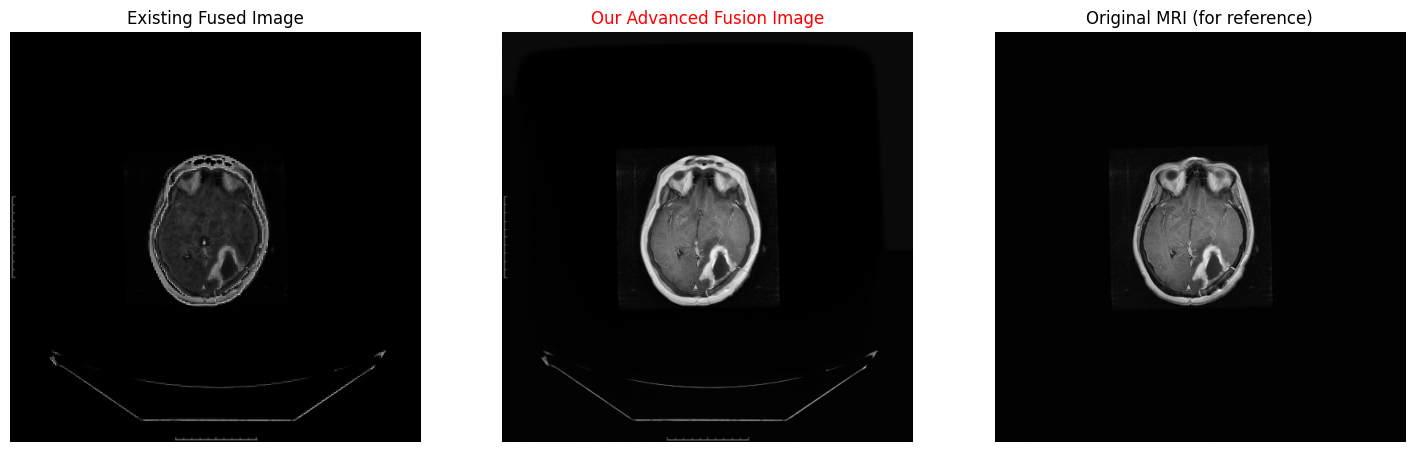

In [ ]:
import cv2
import matplotlib.pyplot as plt

# --- Load Images ---
# Load your existing fused image
existing_fused_path = '/content/drive/MyDrive/project data/sample dataset for Fusion/FUSED/1.jpg'
existing_fused_img = cv2.imread(existing_fused_path, cv2.IMREAD_GRAYSCALE)

# Generate our fused image (using the function from before)
ct_path = os.path.join(CT_PROCESSED_DIR, '1.npy')
mri_path = os.path.join(MRI_PROCESSED_DIR, '1.npy')
ct_processed = load_processed_npy(ct_path)
mri_processed = load_processed_npy(mri_path)
our_fused_img, _, _ = guided_filter_fusion_advanced(ct_processed, mri_processed)

# --- Visualize for Comparison ---
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(existing_fused_img, cmap='gray')
plt.title('Existing Fused Image')
plt.axis('off')

plt.subplot(1, 3, 2)
# We need to normalize our fused image to 0-255 for a fair visual comparison
our_fused_img_display = cv2.normalize(our_fused_img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.imshow(our_fused_img_display, cmap='gray')
plt.title('Our Advanced Fusion Image', color='red')
plt.axis('off')

# For context, let's show the original MRI
original_mri = cv2.normalize(mri_processed, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.subplot(1, 3, 3)
plt.imshow(original_mri, cmap='gray')
plt.title('Original MRI (for reference)')
plt.axis('off')

plt.show()

In [ ]:
# from skimage.metrics import mutual_info_score # Remove this line
from sklearn.metrics import mutual_info_score # Add this line
import math

def calculate_fusion_metrics(fused_img, ct_img, mri_img):
    """Calculates common image fusion metrics."""
    # Ensure images are uint8 for calculations
    fused_img = cv2.normalize(fused_img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    ct_img = cv2.normalize(ct_img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    mri_img = cv2.normalize(mri_img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    metrics = {}

    # 1. Entropy (EN): Measures richness of information. Higher is better.
    hist = cv2.calcHist([fused_img], [0], None, [256], [0, 256])
    hist /= hist.sum()
    metrics['Entropy'] = -np.sum(hist * np.log2(hist + 1e-12))

    # 2. Standard Deviation (SD): Measures contrast. Higher is better.
    metrics['Standard Deviation'] = np.std(fused_img)

    # 3. Spatial Frequency (SF): Measures detail and texture. Higher is better.
    gx = cv2.Sobel(fused_img, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(fused_img, cv2.CV_64F, 0, 1, ksize=3)
    sf = np.sqrt(np.mean(gx**2 + gy**2))
    metrics['Spatial Frequency'] = sf

    # 4. Mutual Information (MI): Measures information transferred from sources. Higher is better.
    mi_ct = mutual_info_score(ct_img.ravel(), fused_img.ravel())
    mi_mri = mutual_info_score(mri_img.ravel(), fused_img.ravel())
    metrics['Mutual Information'] = mi_ct + mi_mri

    return metrics

# --- Calculate and Compare Metrics ---
print("--- Quantitative Comparison of Fusion Methods ---")

# For the existing fused image
metrics_existing = calculate_fusion_metrics(existing_fused_img, ct_processed, mri_processed)
print("\nMetrics for 'Existing Fused Image':")
for key, value in metrics_existing.items():
    print(f"  {key}: {value:.4f}")

# For our advanced fusion image
metrics_our = calculate_fusion_metrics(our_fused_img, ct_processed, mri_processed)
print("\nMetrics for 'Our Advanced Fusion Image':")
for key, value in metrics_our.items():
    print(f"  {key}: {value:.4f}")

--- Quantitative Comparison of Fusion Methods ---

Metrics for 'Existing Fused Image':
  Entropy: 1.7563
  Standard Deviation: 19.8778
  Spatial Frequency: 60.6642
  Mutual Information: 0.8654

Metrics for 'Our Advanced Fusion Image':
  Entropy: 3.4538
  Standard Deviation: 35.2951
  Spatial Frequency: 66.4025
  Mutual Information: 1.1206


experiment 2

here with start with actual dataset and run early baseline early and late fusion

In [ ]:
import os
import numpy as np
from natsort import natsorted

# --- 1. Define the paths to the new labeled dataset ---
MRI_YES_PATH = '/content/drive/MyDrive/project data/sample images/MRIYES1-20230530T135117Z-001/MRIYES1/'
CT_YES_PATH = '/content/drive/MyDrive/project data/sample images/CTYES1/'
MRI_NO_PATH = '/content/drive/MyDrive/project data/sample images/MRINO1/'
CT_NO_PATH = '/content/drive/MyDrive/project data/sample images/CTNO1/'

# --- 2. Get sorted lists of file names ---
mri_yes_files = natsorted([f for f in os.listdir(MRI_YES_PATH) if f.endswith('.jpg')])
ct_yes_files = natsorted([f for f in os.listdir(CT_YES_PATH) if f.endswith('.jpg')])
mri_no_files = natsorted([f for f in os.listdir(MRI_NO_PATH) if f.endswith('.jpg')])
ct_no_files = natsorted([f for f in os.listdir(CT_NO_PATH) if f.endswith('.jpg')])

# --- 3. Create full paths and a combined list for all image pairs ---
# Create pairs for the "YES" class
pairs_yes = []
for mri_f, ct_f in zip(mri_yes_files, ct_yes_files):
    pairs_yes.append({
        'mri_path': os.path.join(MRI_YES_PATH, mri_f),
        'ct_path': os.path.join(CT_YES_PATH, ct_f),
        'label': 1, # 1 for Tumor
        'id': os.path.splitext(mri_f)[0]
    })

# Create pairs for the "NO" class
pairs_no = []
for mri_f, ct_f in zip(mri_no_files, ct_no_files):
    pairs_no.append({
        'mri_path': os.path.join(MRI_NO_PATH, mri_f),
        'ct_path': os.path.join(CT_NO_PATH, ct_f),
        'label': 0, # 0 for No Tumor
        'id': os.path.splitext(mri_f)[0]
    })

# --- 4. Combine into a single master list and create the labels array ---
all_image_pairs = pairs_yes + pairs_no
labels = np.array([p['label'] for p in all_image_pairs])

print(f"Total number of image pairs found: {len(all_image_pairs)}")
print(f"Class distribution:")
print(f"  - Tumor (YES): {np.sum(labels == 1)} images")
print(f"  - No Tumor (NO): {np.sum(labels == 0)} images")

# --- 5. Save the labels array for future use ---
# This is very important! We will load this file for the classification step.
LABELS_SAVE_DIR = '/content/drive/MyDrive/project data/sample images/Features_Labeled/'
os.makedirs(LABELS_SAVE_DIR, exist_ok=True)
np.save(os.path.join(LABELS_SAVE_DIR, 'labels.npy'), labels)
print(f"\nLabels array saved to: {os.path.join(LABELS_SAVE_DIR, 'labels.npy')}")

Total number of image pairs found: 169
Class distribution:
  - Tumor (YES): 85 images
  - No Tumor (NO): 84 images

Labels array saved to: /content/drive/MyDrive/project data/sample images/Features_Labeled/labels.npy


In [ ]:
import cv2
from tqdm import tqdm

# --- 1. Define new output directories for processed labeled data ---
PROCESSED_LABELED_DIR = '/content/drive/MyDrive/project data/sample images/Processed_Labeled_Data/'
MRI_PROCESSED_LABELED_PATH = os.path.join(PROCESSED_LABELED_DIR, 'MRI')
CT_PROCESSED_LABELED_PATH = os.path.join(PROCESSED_LABELED_DIR, 'CT')
os.makedirs(MRI_PROCESSED_LABELED_PATH, exist_ok=True)
os.makedirs(CT_PROCESSED_LABELED_PATH, exist_ok=True)

# --- 2. Re-use the preprocessing function from before ---
# (Ensure 'preprocess_image_pair_for_saving' is defined in your notebook)

# --- 3. Loop, Preprocess, and Save ---
print(f"\nStarting preprocessing for all {len(all_image_pairs)} labeled image pairs...")

for i, pair in tqdm(enumerate(all_image_pairs), total=len(all_image_pairs)):
    # Load raw images
    raw_mri = cv2.imread(pair['mri_path'], cv2.IMREAD_GRAYSCALE)
    raw_ct = cv2.imread(pair['ct_path'], cv2.IMREAD_GRAYSCALE)

    if raw_mri is not None and raw_ct is not None:
        # Preprocess the pair
        processed_mri, processed_ct = preprocess_image_pair_for_saving(raw_mri, raw_ct)

        # Save the processed numpy arrays with a consistent naming scheme (0.npy, 1.npy, etc.)
        np.save(os.path.join(MRI_PROCESSED_LABELED_PATH, f'{i}.npy'), processed_mri)
        np.save(os.path.join(CT_PROCESSED_LABELED_PATH, f'{i}.npy'), processed_ct)

print("\nPreprocessing of the labeled dataset is complete.")
print(f"Processed MRI images saved to: {MRI_PROCESSED_LABELED_PATH}")
print(f"Processed CT images saved to: {CT_PROCESSED_LABELED_PATH}")


Starting preprocessing for all 169 labeled image pairs...


100%|██████████| 169/169 [09:40<00:00,  3.44s/it]


Preprocessing of the labeled dataset is complete.
Processed MRI images saved to: /content/drive/MyDrive/project data/sample images/Processed_Labeled_Data/MRI
Processed CT images saved to: /content/drive/MyDrive/project data/sample images/Processed_Labeled_Data/CT


In [ ]:
# --- 1. Define paths for final labeled features ---
EARLY_FEATURES_LABELED_DIR = os.path.join(LABELS_SAVE_DIR, 'Early_Fusion')
LATE_BASELINE_FEATURES_LABELED_DIR = os.path.join(LABELS_SAVE_DIR, 'Late_Fusion_Baseline')
os.makedirs(EARLY_FEATURES_LABELED_DIR, exist_ok=True)
os.makedirs(LATE_BASELINE_FEATURES_LABELED_DIR, exist_ok=True)

# --- 2. Generate Early Fusion Features ---
print("\n--- Generating and Saving Early Fusion Features for Labeled Dataset ---")
for i in tqdm(range(len(all_image_pairs)), desc="Early Fusion"):
    ct_path = os.path.join(CT_PROCESSED_LABELED_PATH, f'{i}.npy')
    mri_path = os.path.join(MRI_PROCESSED_LABELED_PATH, f'{i}.npy')

    early_features, _, _, _ = run_early_fusion_pipeline(ct_path, mri_path)
    np.save(os.path.join(EARLY_FEATURES_LABELED_DIR, f'{i}.npy'), early_features)

# --- 3. Generate Late Fusion (Baseline) Features ---
print("\n--- Generating and Saving Late Fusion (Baseline) Features for Labeled Dataset ---")
for i in tqdm(range(len(all_image_pairs)), desc="Late Fusion (Baseline)"):
    ct_path = os.path.join(CT_PROCESSED_LABELED_PATH, f'{i}.npy')
    mri_path = os.path.join(MRI_PROCESSED_LABELED_PATH, f'{i}.npy')

    late_features_baseline = run_late_fusion_pipeline_baseline(ct_path, mri_path)
    np.save(os.path.join(LATE_BASELINE_FEATURES_LABELED_DIR, f'{i}.npy'), late_features_baseline)

print("\nAll feature vectors for the labeled dataset have been generated and saved.")


--- Generating and Saving Early Fusion Features for Labeled Dataset ---


Early Fusion:   0%|          | 0/169 [00:00<?, ?it/s]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 0.npy
Loading MRI from: 0.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:   1%|          | 1/169 [00:02<06:43,  2.40s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 1.npy
Loading MRI from: 1.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:   1%|          | 2/169 [00:03<04:16,  1.54s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 2.npy
Loading MRI from: 2.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:   2%|▏         | 3/169 [00:04<03:31,  1.27s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 3.npy
Loading MRI from: 3.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:   2%|▏         | 4/169 [00:05<03:09,  1.15s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 4.npy
Loading MRI from: 4.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:   3%|▎         | 5/169 [00:06<02:55,  1.07s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 5.npy
Loading MRI from: 5.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:   4%|▎         | 6/169 [00:07<02:48,  1.03s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 6.npy
Loading MRI from: 6.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:   4%|▍         | 7/169 [00:08<02:44,  1.02s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 7.npy
Loading MRI from: 7.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:   5%|▍         | 8/169 [00:09<02:39,  1.01it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 8.npy
Loading MRI from: 8.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:   5%|▌         | 9/169 [00:10<02:37,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 9.npy
Loading MRI from: 9.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:   6%|▌         | 10/169 [00:10<02:35,  1.03it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 10.npy
Loading MRI from: 10.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:   7%|▋         | 11/169 [00:11<02:35,  1.01it/s]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 11.npy
Loading MRI from: 11.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:   7%|▋         | 12/169 [00:13<03:00,  1.15s/it]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 12.npy
Loading MRI from: 12.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:   8%|▊         | 13/169 [00:15<03:15,  1.25s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 13.npy
Loading MRI from: 13.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:   8%|▊         | 14/169 [00:16<03:12,  1.24s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 14.npy
Loading MRI from: 14.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:   9%|▉         | 15/169 [00:17<02:56,  1.15s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 15.npy
Loading MRI from: 15.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:   9%|▉         | 16/169 [00:18<02:46,  1.09s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 16.npy
Loading MRI from: 16.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  10%|█         | 17/169 [00:19<02:41,  1.06s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 17.npy
Loading MRI from: 17.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  11%|█         | 18/169 [00:20<02:36,  1.03s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 18.npy
Loading MRI from: 18.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  11%|█         | 19/169 [00:21<02:32,  1.02s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 19.npy
Loading MRI from: 19.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  12%|█▏        | 20/169 [00:21<02:27,  1.01it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 20.npy
Loading MRI from: 20.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  12%|█▏        | 21/169 [00:22<02:24,  1.03it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 21.npy
Loading MRI from: 21.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  13%|█▎        | 22/169 [00:23<02:20,  1.04it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 22.npy
Loading MRI from: 22.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  14%|█▎        | 23/169 [00:24<02:19,  1.05it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 23.npy
Loading MRI from: 23.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  14%|█▍        | 24/169 [00:25<02:17,  1.06it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 24.npy
Loading MRI from: 24.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  15%|█▍        | 25/169 [00:27<02:37,  1.09s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 25.npy
Loading MRI from: 25.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  15%|█▌        | 26/169 [00:28<02:53,  1.22s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 26.npy
Loading MRI from: 26.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:  16%|█▌        | 27/169 [00:30<03:02,  1.29s/it]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 27.npy
Loading MRI from: 27.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  17%|█▋        | 28/169 [00:31<02:47,  1.19s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 28.npy
Loading MRI from: 28.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  17%|█▋        | 29/169 [00:32<02:36,  1.12s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 29.npy
Loading MRI from: 29.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  18%|█▊        | 30/169 [00:32<02:27,  1.06s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 30.npy
Loading MRI from: 30.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  18%|█▊        | 31/169 [00:33<02:22,  1.03s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 31.npy
Loading MRI from: 31.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  19%|█▉        | 32/169 [00:34<02:20,  1.03s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 32.npy
Loading MRI from: 32.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  20%|█▉        | 33/169 [00:35<02:15,  1.00it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 33.npy
Loading MRI from: 33.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  20%|██        | 34/169 [00:36<02:14,  1.01it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 34.npy
Loading MRI from: 34.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  21%|██        | 35/169 [00:37<02:11,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 35.npy
Loading MRI from: 35.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  21%|██▏       | 36/169 [00:38<02:09,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 36.npy
Loading MRI from: 36.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  22%|██▏       | 37/169 [00:39<02:08,  1.03it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 37.npy
Loading MRI from: 37.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:  22%|██▏       | 38/169 [00:41<02:23,  1.09s/it]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 38.npy
Loading MRI from: 38.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...


Early Fusion:  23%|██▎       | 39/169 [00:42<02:38,  1.22s/it]

  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 39.npy
Loading MRI from: 39.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:  24%|██▎       | 40/169 [00:44<02:46,  1.29s/it]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 40.npy
Loading MRI from: 40.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  24%|██▍       | 41/169 [00:45<02:33,  1.20s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 41.npy
Loading MRI from: 41.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  25%|██▍       | 42/169 [00:46<02:22,  1.13s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 42.npy
Loading MRI from: 42.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  25%|██▌       | 43/169 [00:46<02:15,  1.07s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 43.npy
Loading MRI from: 43.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  26%|██▌       | 44/169 [00:47<02:09,  1.04s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 44.npy
Loading MRI from: 44.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  27%|██▋       | 45/169 [00:48<02:06,  1.02s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 45.npy
Loading MRI from: 45.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  27%|██▋       | 46/169 [00:49<02:03,  1.01s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 46.npy
Loading MRI from: 46.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  28%|██▊       | 47/169 [00:50<02:00,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 47.npy
Loading MRI from: 47.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  28%|██▊       | 48/169 [00:51<01:58,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 48.npy
Loading MRI from: 48.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  29%|██▉       | 49/169 [00:52<01:55,  1.04it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 49.npy
Loading MRI from: 49.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  30%|██▉       | 50/169 [00:53<01:54,  1.04it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 50.npy
Loading MRI from: 50.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  30%|███       | 51/169 [00:54<02:04,  1.05s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 51.npy
Loading MRI from: 51.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:  31%|███       | 52/169 [00:56<02:17,  1.18s/it]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 52.npy
Loading MRI from: 52.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:  31%|███▏      | 53/169 [00:57<02:26,  1.26s/it]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 53.npy
Loading MRI from: 53.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  32%|███▏      | 54/169 [00:58<02:18,  1.21s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 54.npy
Loading MRI from: 54.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  33%|███▎      | 55/169 [00:59<02:08,  1.13s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 55.npy
Loading MRI from: 55.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  33%|███▎      | 56/169 [01:00<02:02,  1.09s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 56.npy
Loading MRI from: 56.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  34%|███▎      | 57/169 [01:01<01:57,  1.05s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 57.npy
Loading MRI from: 57.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  34%|███▍      | 58/169 [01:02<01:54,  1.03s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 58.npy
Loading MRI from: 58.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  35%|███▍      | 59/169 [01:03<01:50,  1.00s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 59.npy
Loading MRI from: 59.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  36%|███▌      | 60/169 [01:04<01:48,  1.01it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 60.npy
Loading MRI from: 60.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  36%|███▌      | 61/169 [01:05<01:45,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 61.npy
Loading MRI from: 61.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  37%|███▋      | 62/169 [01:06<01:42,  1.04it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 62.npy
Loading MRI from: 62.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  37%|███▋      | 63/169 [01:07<01:40,  1.05it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 63.npy
Loading MRI from: 63.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:  38%|███▊      | 64/169 [01:08<01:42,  1.02it/s]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 64.npy
Loading MRI from: 64.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:  38%|███▊      | 65/169 [01:10<01:59,  1.15s/it]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 65.npy
Loading MRI from: 65.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  39%|███▉      | 66/169 [01:11<02:10,  1.27s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 66.npy
Loading MRI from: 66.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  40%|███▉      | 67/169 [01:12<02:08,  1.26s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 67.npy
Loading MRI from: 67.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  40%|████      | 68/169 [01:13<01:57,  1.16s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 68.npy
Loading MRI from: 68.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  41%|████      | 69/169 [01:14<01:49,  1.10s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 69.npy
Loading MRI from: 69.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  41%|████▏     | 70/169 [01:15<01:44,  1.05s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 70.npy
Loading MRI from: 70.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  42%|████▏     | 71/169 [01:16<01:39,  1.02s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 71.npy
Loading MRI from: 71.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  43%|████▎     | 72/169 [01:17<01:37,  1.01s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 72.npy
Loading MRI from: 72.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  43%|████▎     | 73/169 [01:18<01:34,  1.01it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 73.npy
Loading MRI from: 73.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  44%|████▍     | 74/169 [01:19<01:33,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 74.npy
Loading MRI from: 74.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  44%|████▍     | 75/169 [01:20<01:31,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 75.npy
Loading MRI from: 75.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  45%|████▍     | 76/169 [01:21<01:29,  1.04it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 76.npy
Loading MRI from: 76.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  46%|████▌     | 77/169 [01:22<01:29,  1.03it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 77.npy
Loading MRI from: 77.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  46%|████▌     | 78/169 [01:23<01:44,  1.15s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 78.npy
Loading MRI from: 78.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  47%|████▋     | 79/169 [01:25<01:52,  1.26s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 79.npy
Loading MRI from: 79.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  47%|████▋     | 80/169 [01:26<01:53,  1.28s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 80.npy
Loading MRI from: 80.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  48%|████▊     | 81/169 [01:27<01:44,  1.19s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 81.npy
Loading MRI from: 81.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  49%|████▊     | 82/169 [01:28<01:37,  1.12s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 82.npy
Loading MRI from: 82.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  49%|████▉     | 83/169 [01:29<01:31,  1.06s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 83.npy
Loading MRI from: 83.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  50%|████▉     | 84/169 [01:30<01:27,  1.03s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 84.npy
Loading MRI from: 84.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  50%|█████     | 85/169 [01:31<01:25,  1.01s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 85.npy
Loading MRI from: 85.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  51%|█████     | 86/169 [01:32<01:23,  1.00s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 86.npy
Loading MRI from: 86.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  51%|█████▏    | 87/169 [01:33<01:21,  1.01it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 87.npy
Loading MRI from: 87.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  52%|█████▏    | 88/169 [01:34<01:20,  1.01it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 88.npy
Loading MRI from: 88.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  53%|█████▎    | 89/169 [01:35<01:19,  1.00it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 89.npy
Loading MRI from: 89.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  53%|█████▎    | 90/169 [01:36<01:17,  1.01it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 90.npy
Loading MRI from: 90.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:  54%|█████▍    | 91/169 [01:38<01:29,  1.14s/it]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 91.npy
Loading MRI from: 91.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  54%|█████▍    | 92/169 [01:39<01:35,  1.24s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 92.npy
Loading MRI from: 92.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  55%|█████▌    | 93/169 [01:40<01:36,  1.27s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 93.npy
Loading MRI from: 93.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  56%|█████▌    | 94/169 [01:41<01:28,  1.17s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 94.npy
Loading MRI from: 94.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  56%|█████▌    | 95/169 [01:42<01:22,  1.11s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 95.npy
Loading MRI from: 95.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  57%|█████▋    | 96/169 [01:43<01:17,  1.06s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 96.npy
Loading MRI from: 96.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  57%|█████▋    | 97/169 [01:44<01:14,  1.03s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 97.npy
Loading MRI from: 97.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  58%|█████▊    | 98/169 [01:45<01:12,  1.02s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 98.npy
Loading MRI from: 98.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  59%|█████▊    | 99/169 [01:46<01:09,  1.00it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 99.npy
Loading MRI from: 99.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  59%|█████▉    | 100/169 [01:47<01:07,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 100.npy
Loading MRI from: 100.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  60%|█████▉    | 101/169 [01:48<01:06,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 101.npy
Loading MRI from: 101.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  60%|██████    | 102/169 [01:49<01:05,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 102.npy
Loading MRI from: 102.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  61%|██████    | 103/169 [01:50<01:04,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 103.npy
Loading MRI from: 103.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  62%|██████▏   | 104/169 [01:51<01:12,  1.12s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 104.npy
Loading MRI from: 104.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  62%|██████▏   | 105/169 [01:53<01:19,  1.24s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 105.npy
Loading MRI from: 105.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  63%|██████▎   | 106/169 [01:54<01:20,  1.28s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 106.npy
Loading MRI from: 106.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  63%|██████▎   | 107/169 [01:55<01:13,  1.19s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 107.npy
Loading MRI from: 107.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  64%|██████▍   | 108/169 [01:56<01:07,  1.11s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 108.npy
Loading MRI from: 108.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  64%|██████▍   | 109/169 [01:57<01:04,  1.08s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 109.npy
Loading MRI from: 109.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  65%|██████▌   | 110/169 [01:58<01:01,  1.05s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 110.npy
Loading MRI from: 110.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  66%|██████▌   | 111/169 [01:59<00:58,  1.01s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 111.npy
Loading MRI from: 111.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  66%|██████▋   | 112/169 [02:00<00:56,  1.01it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 112.npy
Loading MRI from: 112.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  67%|██████▋   | 113/169 [02:01<00:54,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 113.npy
Loading MRI from: 113.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  67%|██████▋   | 114/169 [02:02<00:54,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 114.npy
Loading MRI from: 114.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  68%|██████▊   | 115/169 [02:03<00:52,  1.03it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 115.npy
Loading MRI from: 115.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  69%|██████▊   | 116/169 [02:04<00:50,  1.04it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 116.npy
Loading MRI from: 116.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  69%|██████▉   | 117/169 [02:05<00:55,  1.06s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 117.npy
Loading MRI from: 117.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:  70%|██████▉   | 118/169 [02:07<01:00,  1.18s/it]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 118.npy
Loading MRI from: 118.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:  70%|███████   | 119/169 [02:08<01:03,  1.28s/it]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 119.npy
Loading MRI from: 119.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  71%|███████   | 120/169 [02:09<00:58,  1.20s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 120.npy
Loading MRI from: 120.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  72%|███████▏  | 121/169 [02:10<00:54,  1.13s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 121.npy
Loading MRI from: 121.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  72%|███████▏  | 122/169 [02:11<00:50,  1.08s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 122.npy
Loading MRI from: 122.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  73%|███████▎  | 123/169 [02:12<00:48,  1.05s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 123.npy
Loading MRI from: 123.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  73%|███████▎  | 124/169 [02:13<00:46,  1.03s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 124.npy
Loading MRI from: 124.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  74%|███████▍  | 125/169 [02:14<00:44,  1.01s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 125.npy
Loading MRI from: 125.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  75%|███████▍  | 126/169 [02:15<00:43,  1.00s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 126.npy
Loading MRI from: 126.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  75%|███████▌  | 127/169 [02:16<00:41,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 127.npy
Loading MRI from: 127.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  76%|███████▌  | 128/169 [02:17<00:39,  1.03it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 128.npy
Loading MRI from: 128.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  76%|███████▋  | 129/169 [02:18<00:38,  1.04it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 129.npy
Loading MRI from: 129.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:  77%|███████▋  | 130/169 [02:19<00:40,  1.04s/it]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 130.npy
Loading MRI from: 130.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  78%|███████▊  | 131/169 [02:21<00:44,  1.16s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 131.npy
Loading MRI from: 131.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:  78%|███████▊  | 132/169 [02:22<00:46,  1.26s/it]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 132.npy
Loading MRI from: 132.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  79%|███████▊  | 133/169 [02:23<00:43,  1.20s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 133.npy
Loading MRI from: 133.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  79%|███████▉  | 134/169 [02:24<00:39,  1.12s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 134.npy
Loading MRI from: 134.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  80%|███████▉  | 135/169 [02:25<00:36,  1.08s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 135.npy
Loading MRI from: 135.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  80%|████████  | 136/169 [02:26<00:34,  1.03s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 136.npy
Loading MRI from: 136.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  81%|████████  | 137/169 [02:27<00:32,  1.00s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 137.npy
Loading MRI from: 137.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  82%|████████▏ | 138/169 [02:28<00:30,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 138.npy
Loading MRI from: 138.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  82%|████████▏ | 139/169 [02:29<00:28,  1.04it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 139.npy
Loading MRI from: 139.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  83%|████████▎ | 140/169 [02:30<00:27,  1.05it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 140.npy
Loading MRI from: 140.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  83%|████████▎ | 141/169 [02:31<00:26,  1.05it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 141.npy
Loading MRI from: 141.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  84%|████████▍ | 142/169 [02:32<00:25,  1.04it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 142.npy
Loading MRI from: 142.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  85%|████████▍ | 143/169 [02:33<00:25,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 143.npy
Loading MRI from: 143.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...


Early Fusion:  85%|████████▌ | 144/169 [02:34<00:28,  1.15s/it]

  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 144.npy
Loading MRI from: 144.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...


Early Fusion:  86%|████████▌ | 145/169 [02:36<00:30,  1.26s/it]

  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 145.npy
Loading MRI from: 145.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  86%|████████▋ | 146/169 [02:37<00:29,  1.28s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 146.npy
Loading MRI from: 146.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  87%|████████▋ | 147/169 [02:38<00:25,  1.17s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 147.npy
Loading MRI from: 147.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  88%|████████▊ | 148/169 [02:39<00:23,  1.10s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 148.npy
Loading MRI from: 148.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  88%|████████▊ | 149/169 [02:40<00:20,  1.05s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 149.npy
Loading MRI from: 149.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  89%|████████▉ | 150/169 [02:41<00:19,  1.01s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 150.npy
Loading MRI from: 150.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  89%|████████▉ | 151/169 [02:42<00:17,  1.00it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 151.npy
Loading MRI from: 151.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  90%|████████▉ | 152/169 [02:43<00:16,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 152.npy
Loading MRI from: 152.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  91%|█████████ | 153/169 [02:44<00:15,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 153.npy
Loading MRI from: 153.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  91%|█████████ | 154/169 [02:45<00:14,  1.01it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 154.npy
Loading MRI from: 154.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  92%|█████████▏| 155/169 [02:46<00:13,  1.00it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 155.npy
Loading MRI from: 155.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  92%|█████████▏| 156/169 [02:46<00:12,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 156.npy
Loading MRI from: 156.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =


Early Fusion:  93%|█████████▎| 157/169 [02:48<00:13,  1.13s/it]

=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 157.npy
Loading MRI from: 157.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  93%|█████████▎| 158/169 [02:49<00:13,  1.24s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 158.npy
Loading MRI from: 158.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  94%|█████████▍| 159/169 [02:51<00:12,  1.27s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 159.npy
Loading MRI from: 159.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  95%|█████████▍| 160/169 [02:52<00:10,  1.18s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 160.npy
Loading MRI from: 160.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  95%|█████████▌| 161/169 [02:53<00:08,  1.10s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 161.npy
Loading MRI from: 161.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  96%|█████████▌| 162/169 [02:54<00:07,  1.06s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 162.npy
Loading MRI from: 162.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  96%|█████████▋| 163/169 [02:55<00:06,  1.03s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 163.npy
Loading MRI from: 163.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  97%|█████████▋| 164/169 [02:56<00:05,  1.02s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 164.npy
Loading MRI from: 164.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  98%|█████████▊| 165/169 [02:57<00:04,  1.01s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 165.npy
Loading MRI from: 165.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  98%|█████████▊| 166/169 [02:58<00:02,  1.00it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 166.npy
Loading MRI from: 166.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  99%|█████████▉| 167/169 [02:59<00:01,  1.02it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 167.npy
Loading MRI from: 167.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion:  99%|█████████▉| 168/169 [02:59<00:00,  1.03it/s]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =
=      STARTING EARLY FUSION PIPELINE       =
Loading CT from: 168.npy
Loading MRI from: 168.npy
--- Starting Advanced Guided Filter Fusion ---
--- Fusion Complete ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Early Fusion: 100%|██████████| 169/169 [03:00<00:00,  1.07s/it]


  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

=       EARLY FUSION PIPELINE COMPLETE      =

--- Generating and Saving Late Fusion (Baseline) Features for Labeled Dataset ---


Late Fusion (Baseline):   0%|          | 0/169 [00:00<?, ?it/s]

=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):   1%|          | 1/169 [00:02<07:43,  2.76s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):   1%|          | 2/169 [00:05<07:04,  2.54s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):   2%|▏         | 3/169 [00:07<06:09,  2.23s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):   2%|▏         | 4/169 [00:08<05:36,  2.04s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):   3%|▎         | 5/169 [00:10<05:19,  1.95s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):   4%|▎         | 6/169 [00:12<05:08,  1.89s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):   4%|▍         | 7/169 [00:14<05:02,  1.86s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...


Late Fusion (Baseline):   5%|▍         | 8/169 [00:16<05:50,  2.17s/it]

  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):   5%|▌         | 9/169 [00:19<05:59,  2.24s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):   6%|▌         | 10/169 [00:21<05:36,  2.11s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):   7%|▋         | 11/169 [00:22<05:17,  2.01s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):   7%|▋         | 12/169 [00:24<05:04,  1.94s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):   8%|▊         | 13/169 [00:26<04:57,  1.91s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):   8%|▊         | 14/169 [00:28<04:49,  1.87s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):   9%|▉         | 15/169 [00:30<05:22,  2.10s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):   9%|▉         | 16/169 [00:33<05:35,  2.19s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  10%|█         | 17/169 [00:35<05:17,  2.09s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  11%|█         | 18/169 [00:37<05:02,  2.00s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  11%|█         | 19/169 [00:38<04:51,  1.94s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  12%|█▏        | 20/169 [00:40<04:43,  1.90s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  12%|█▏        | 21/169 [00:42<04:37,  1.87s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE 

Late Fusion (Baseline):  13%|█▎        | 22/169 [00:45<05:12,  2.13s/it]

=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  14%|█▎        | 23/169 [00:47<05:25,  2.23s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  14%|█▍        | 24/169 [00:49<05:04,  2.10s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  15%|█▍        | 25/169 [00:51<04:47,  2.00s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  15%|█▌        | 26/169 [00:52<04:35,  1.93s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  16%|█▌        | 27/169 [00:54<04:25,  1.87s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  17%|█▋        | 28/169 [00:56<04:23,  1.87s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...


Late Fusion (Baseline):  17%|█▋        | 29/169 [00:59<04:53,  2.10s/it]

  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...


Late Fusion (Baseline):  18%|█▊        | 30/169 [01:02<05:33,  2.40s/it]

  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  18%|█▊        | 31/169 [01:05<05:46,  2.51s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  19%|█▉        | 32/169 [01:06<05:16,  2.31s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  20%|█▉        | 33/169 [01:08<04:53,  2.16s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  20%|██        | 34/169 [01:10<04:35,  2.04s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  21%|██        | 35/169 [01:12<04:24,  1.97s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  21%|██▏       | 36/169 [01:15<04:56,  2.23s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  22%|██▏       | 37/169 [01:17<04:57,  2.25s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  22%|██▏       | 38/169 [01:19<04:37,  2.12s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  23%|██▎       | 39/169 [01:21<04:23,  2.02s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  24%|██▎       | 40/169 [01:22<04:11,  1.95s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  24%|██▍       | 41/169 [01:24<04:00,  1.88s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  25%|██▍       | 42/169 [01:26<03:54,  1.85s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...


Late Fusion (Baseline):  25%|██▌       | 43/169 [01:29<04:31,  2.16s/it]

  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  26%|██▌       | 44/169 [01:31<04:33,  2.19s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  27%|██▋       | 45/169 [01:33<04:16,  2.07s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  27%|██▋       | 46/169 [01:35<04:04,  1.99s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  28%|██▊       | 47/169 [01:36<03:54,  1.92s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  28%|██▊       | 48/169 [01:38<03:49,  1.90s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  29%|██▉       | 49/169 [01:40<03:45,  1.88s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  30%|██▉       | 50/169 [01:43<04:15,  2.15s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  30%|███       | 51/169 [01:45<04:17,  2.19s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  31%|███       | 52/169 [01:47<04:01,  2.06s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  31%|███▏      | 53/169 [01:49<03:50,  1.99s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  32%|███▏      | 54/169 [01:50<03:43,  1.94s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  33%|███▎      | 55/169 [01:52<03:35,  1.89s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  33%|███▎      | 56/169 [01:54<03:30,  1.86s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  34%|███▎      | 57/169 [01:57<03:58,  2.13s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  34%|███▍      | 58/169 [01:59<04:05,  2.21s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  35%|███▍      | 59/169 [02:01<03:48,  2.08s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  36%|███▌      | 60/169 [02:03<03:37,  1.99s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  36%|███▌      | 61/169 [02:05<03:29,  1.94s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  37%|███▋      | 62/169 [02:06<03:22,  1.89s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  37%|███▋      | 63/169 [02:08<03:16,  1.86s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE 

Late Fusion (Baseline):  38%|███▊      | 64/169 [02:11<03:43,  2.13s/it]

=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  38%|███▊      | 65/169 [02:13<03:49,  2.21s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  39%|███▉      | 66/169 [02:15<03:34,  2.08s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  40%|███▉      | 67/169 [02:17<03:23,  1.99s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  40%|████      | 68/169 [02:19<03:14,  1.92s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  41%|████      | 69/169 [02:20<03:09,  1.89s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  41%|████▏     | 70/169 [02:22<03:04,  1.86s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  42%|████▏     | 71/169 [02:25<03:24,  2.08s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  43%|████▎     | 72/169 [02:27<03:33,  2.20s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  43%|████▎     | 73/169 [02:29<03:21,  2.10s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  44%|████▍     | 74/169 [02:31<03:12,  2.03s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  44%|████▍     | 75/169 [02:33<03:02,  1.94s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  45%|████▍     | 76/169 [02:35<02:57,  1.91s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  46%|████▌     | 77/169 [02:36<02:51,  1.87s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE 

Late Fusion (Baseline):  46%|████▌     | 78/169 [02:39<03:11,  2.10s/it]

=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  47%|████▋     | 79/169 [02:42<03:20,  2.23s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  47%|████▋     | 80/169 [02:43<03:06,  2.09s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  48%|████▊     | 81/169 [02:45<02:56,  2.00s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  49%|████▊     | 82/169 [02:47<02:48,  1.94s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  49%|████▉     | 83/169 [02:49<02:43,  1.90s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  50%|████▉     | 84/169 [02:51<02:43,  1.92s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  50%|█████     | 85/169 [02:53<03:04,  2.19s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  51%|█████     | 86/169 [02:56<03:05,  2.24s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  51%|█████▏    | 87/169 [02:58<02:52,  2.11s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  52%|█████▏    | 88/169 [02:59<02:41,  2.00s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  53%|█████▎    | 89/169 [03:01<02:37,  1.97s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  53%|█████▎    | 90/169 [03:03<02:32,  1.93s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  54%|█████▍    | 91/169 [03:05<02:28,  1.91s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...


Late Fusion (Baseline):  54%|█████▍    | 92/169 [03:08<02:47,  2.17s/it]

  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  55%|█████▌    | 93/169 [03:10<02:47,  2.20s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  56%|█████▌    | 94/169 [03:12<02:37,  2.10s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  56%|█████▌    | 95/169 [03:14<02:28,  2.01s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  57%|█████▋    | 96/169 [03:15<02:21,  1.93s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  57%|█████▋    | 97/169 [03:17<02:15,  1.89s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  58%|█████▊    | 98/169 [03:19<02:11,  1.86s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  59%|█████▊    | 99/169 [03:22<02:29,  2.13s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  59%|█████▉    | 100/169 [03:24<02:31,  2.20s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  60%|█████▉    | 101/169 [03:26<02:21,  2.08s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  60%|██████    | 102/169 [03:28<02:11,  1.97s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  61%|██████    | 103/169 [03:29<02:06,  1.91s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  62%|██████▏   | 104/169 [03:31<02:01,  1.88s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  62%|██████▏   | 105/169 [03:33<01:58,  1.86s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  63%|██████▎   | 106/169 [03:36<02:12,  2.10s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  63%|██████▎   | 107/169 [03:38<02:16,  2.20s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  64%|██████▍   | 108/169 [03:40<02:06,  2.07s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  64%|██████▍   | 109/169 [03:42<01:58,  1.98s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  65%|██████▌   | 110/169 [03:43<01:53,  1.92s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  66%|██████▌   | 111/169 [03:45<01:49,  1.89s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  66%|██████▋   | 112/169 [03:47<01:46,  1.87s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE 

Late Fusion (Baseline):  67%|██████▋   | 113/169 [03:50<01:56,  2.08s/it]

=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  67%|██████▋   | 114/169 [03:52<02:02,  2.23s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  68%|██████▊   | 115/169 [03:54<01:53,  2.10s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  69%|██████▊   | 116/169 [03:56<01:46,  2.01s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  69%|██████▉   | 117/169 [03:58<01:40,  1.94s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  70%|██████▉   | 118/169 [03:59<01:37,  1.91s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  70%|███████   | 119/169 [04:01<01:33,  1.87s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...


Late Fusion (Baseline):  71%|███████   | 120/169 [04:04<01:41,  2.08s/it]

  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  72%|███████▏  | 121/169 [04:06<01:47,  2.23s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  72%|███████▏  | 122/169 [04:08<01:38,  2.09s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  73%|███████▎  | 123/169 [04:10<01:31,  1.99s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  73%|███████▎  | 124/169 [04:12<01:27,  1.94s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  74%|███████▍  | 125/169 [04:14<01:23,  1.90s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  75%|███████▍  | 126/169 [04:15<01:20,  1.88s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  75%|███████▌  | 127/169 [04:18<01:25,  2.04s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  76%|███████▌  | 128/169 [04:20<01:30,  2.21s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  76%|███████▋  | 129/169 [04:22<01:23,  2.09s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  77%|███████▋  | 130/169 [04:24<01:18,  2.01s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  78%|███████▊  | 131/169 [04:26<01:14,  1.96s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  78%|███████▊  | 132/169 [04:28<01:10,  1.89s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  79%|███████▊  | 133/169 [04:29<01:06,  1.86s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  79%|███████▉  | 134/169 [04:32<01:10,  2.01s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  80%|███████▉  | 135/169 [04:34<01:15,  2.23s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  80%|████████  | 136/169 [04:36<01:10,  2.14s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  81%|████████  | 137/169 [04:38<01:04,  2.03s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  82%|████████▏ | 138/169 [04:40<01:00,  1.96s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  82%|████████▏ | 139/169 [04:42<00:57,  1.92s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  83%|████████▎ | 140/169 [04:44<00:54,  1.88s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE 

Late Fusion (Baseline):  83%|████████▎ | 141/169 [04:46<00:58,  2.08s/it]

=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  84%|████████▍ | 142/169 [04:49<01:00,  2.25s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  85%|████████▍ | 143/169 [04:51<00:54,  2.11s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  85%|████████▌ | 144/169 [04:52<00:50,  2.02s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  86%|████████▌ | 145/169 [04:54<00:46,  1.94s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  86%|████████▋ | 146/169 [04:56<00:44,  1.92s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  87%|████████▋ | 147/169 [04:58<00:41,  1.89s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  88%|████████▊ | 148/169 [05:00<00:43,  2.06s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  88%|████████▊ | 149/169 [05:03<00:44,  2.23s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  89%|████████▉ | 150/169 [05:05<00:39,  2.10s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  89%|████████▉ | 151/169 [05:07<00:36,  2.03s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  90%|████████▉ | 152/169 [05:08<00:33,  1.96s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  91%|█████████ | 153/169 [05:10<00:30,  1.91s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  91%|█████████ | 154/169 [05:12<00:28,  1.87s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE 

Late Fusion (Baseline):  92%|█████████▏| 155/169 [05:14<00:28,  2.06s/it]

=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  92%|█████████▏| 156/169 [05:17<00:28,  2.23s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  93%|█████████▎| 157/169 [05:19<00:25,  2.12s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  93%|█████████▎| 158/169 [05:21<00:22,  2.03s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  94%|█████████▍| 159/169 [05:23<00:19,  1.97s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  95%|█████████▍| 160/169 [05:24<00:17,  1.93s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  95%|█████████▌| 161/169 [05:26<00:15,  1.91s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE 

Late Fusion (Baseline):  96%|█████████▌| 162/169 [05:29<00:14,  2.14s/it]

=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  96%|█████████▋| 163/169 [05:32<00:13,  2.28s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  97%|█████████▋| 164/169 [05:33<00:10,  2.14s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  98%|█████████▊| 165/169 [05:35<00:08,  2.04s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  98%|█████████▊| 166/169 [05:37<00:05,  1.98s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  99%|█████████▉| 167/169 [05:39<00:03,  1.95s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline):  99%|█████████▉| 168/169 [05:41<00:01,  1.92s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =
=  STARTING LATE FUSION PIPELINE (BASELINE) =

--- Processing CT Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...
  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Processing MRI Stream ---
--- Starting Ensemble Feature Extraction ---
Extracting ResNet18 features...
  > Shape: (512,)
Extracting EfficientNet-B0 features...
  > Shape: (1280,)
Extracting ViT-B/16 features...


Late Fusion (Baseline): 100%|██████████| 169/169 [05:44<00:00,  2.04s/it]

  > Shape: (768,)
Extracting Handcrafted features...
  > Shape: (8214,)
--- Final Combined Feature Vector Shape: (10774,) ---

--- Fusing features via Concatenation ---

=     LATE FUSION (BASELINE) COMPLETE       =

All feature vectors for the labeled dataset have been generated and saved.


In [ ]:
import numpy as np
import os
from natsort import natsorted
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Define paths to your final feature sets and labels ---
FEATURES_BASE_DIR = '/content/drive/MyDrive/project data/sample images/Features_Labeled/'
LABELS_PATH = os.path.join(FEATURES_BASE_DIR, 'labels.npy')

# Dictionary to hold the paths for each fusion strategy's features
feature_paths = {
    "Early Fusion": os.path.join(FEATURES_BASE_DIR, 'Early_Fusion'),
    "Late Fusion (Baseline)": os.path.join(FEATURES_BASE_DIR, 'Late_Fusion_Baseline')
}

def load_features_and_labels(feature_dir, labels_path):
    """Loads all feature vectors from a directory and the corresponding labels."""

    # Load feature files in natural sort order to match labels
    feature_files = natsorted([f for f in os.listdir(feature_dir) if f.endswith('.npy')])

    features = []
    for f in feature_files:
        features.append(np.load(os.path.join(feature_dir, f)))

    # Stack into a single 2D array (samples, features)
    X = np.array(features)
    # Load the labels
    y = np.load(labels_path)

    print(f"Loaded dataset from {os.path.basename(feature_dir)}:")
    print(f"  - Features shape (X): {X.shape}")
    print(f"  - Labels shape (y): {y.shape}")

    return X, y

In [ ]:
def train_and_evaluate(X, y, model, model_name, fusion_strategy):
    """
    Trains and evaluates a given classifier on the provided dataset.
    """
    print("\n" + "="*50)
    print(f"Training '{model_name}' on '{fusion_strategy}' features")
    print("="*50)

    # 1. Split data into training and testing sets (80% train, 20% test)
    # stratify=y ensures the proportion of classes is the same in train and test splits
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Training set size: {X_train.shape[0]}, Testing set size: {X_test.shape[0]}")

    # 2. Create a pipeline to scale data and then classify
    pipeline = Pipeline([
        ('scaler', StandardScaler()), # Standardize features by removing the mean and scaling to unit variance
        ('classifier', model)
    ])

    # 3. Train the model
    pipeline.fit(X_train, y_train)

    # 4. Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # 5. Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("\n--- Evaluation Metrics ---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=['No Tumor', 'Tumor']))

    # 6. Visualize the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Tumor', 'Tumor'],
                yticklabels=['No Tumor', 'Tumor'])
    plt.title(f'Confusion Matrix: {model_name} on {fusion_strategy}')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

    # Return the metrics for final comparison
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

Loaded dataset from Early_Fusion:
  - Features shape (X): (169, 10774)
  - Labels shape (y): (169,)

Training 'SVM' on 'Early Fusion' features
Training set size: 135, Testing set size: 34

--- Evaluation Metrics ---
Accuracy:  0.8824
Precision: 0.9333
Recall:    0.8235
F1-Score:  0.8750

--- Classification Report ---
              precision    recall  f1-score   support

    No Tumor       0.84      0.94      0.89        17
       Tumor       0.93      0.82      0.88        17

    accuracy                           0.88        34
   macro avg       0.89      0.88      0.88        34
weighted avg       0.89      0.88      0.88        34



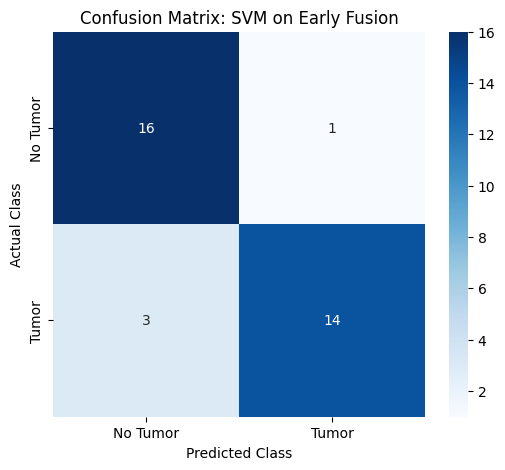


Training 'Random Forest' on 'Early Fusion' features
Training set size: 135, Testing set size: 34

--- Evaluation Metrics ---
Accuracy:  0.9118
Precision: 0.9375
Recall:    0.8824
F1-Score:  0.9091

--- Classification Report ---
              precision    recall  f1-score   support

    No Tumor       0.89      0.94      0.91        17
       Tumor       0.94      0.88      0.91        17

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34



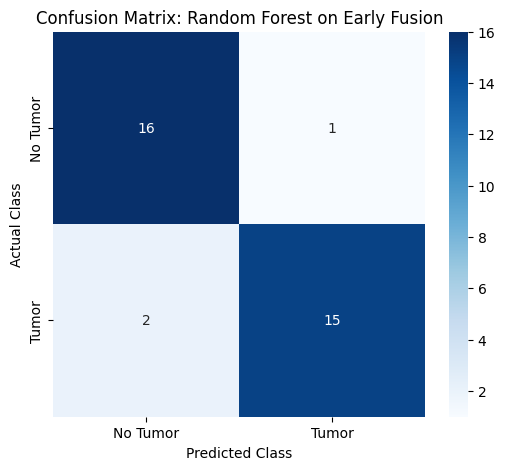

Loaded dataset from Late_Fusion_Baseline:
  - Features shape (X): (169, 21548)
  - Labels shape (y): (169,)

Training 'SVM' on 'Late Fusion (Baseline)' features
Training set size: 135, Testing set size: 34

--- Evaluation Metrics ---
Accuracy:  0.9118
Precision: 1.0000
Recall:    0.8235
F1-Score:  0.9032

--- Classification Report ---
              precision    recall  f1-score   support

    No Tumor       0.85      1.00      0.92        17
       Tumor       1.00      0.82      0.90        17

    accuracy                           0.91        34
   macro avg       0.93      0.91      0.91        34
weighted avg       0.92      0.91      0.91        34



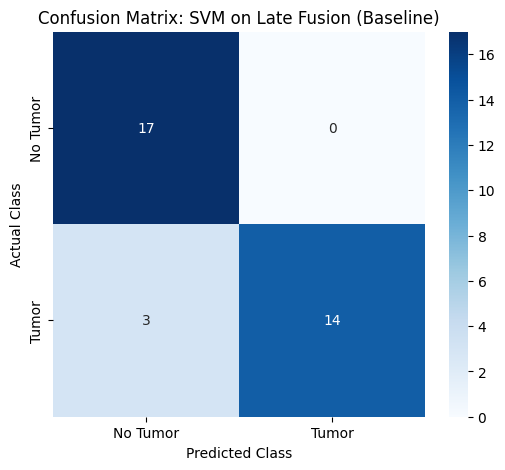


Training 'Random Forest' on 'Late Fusion (Baseline)' features
Training set size: 135, Testing set size: 34

--- Evaluation Metrics ---
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000

--- Classification Report ---
              precision    recall  f1-score   support

    No Tumor       1.00      1.00      1.00        17
       Tumor       1.00      1.00      1.00        17

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34



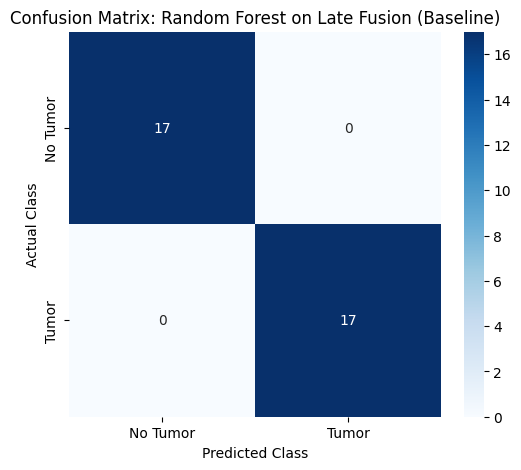

In [ ]:
# --- Define the classifiers we want to test ---
classifiers = {
    "SVM": SVC(kernel='rbf', C=1.0, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# --- Store results for final comparison ---
results = []

# --- Main Experimental Loop ---
for strategy_name, path in feature_paths.items():
    # Load the dataset for the current fusion strategy
    X, y = load_features_and_labels(path, LABELS_PATH)

    for model_name, model in classifiers.items():
        # Train and evaluate the model
        metrics = train_and_evaluate(X, y, model, model_name, strategy_name)

        # Store the results
        results.append({
            'Fusion Strategy': strategy_name,
            'Classifier': model_name,
            **metrics  # Unpack the metrics dictionary
        })

# --- Convert results to a pandas DataFrame for a clean summary ---
results_df = pd.DataFrame(results)

In [ ]:
print("\n" + "#"*60)
print("#" + " "*21 + "FINAL RESULTS SUMMARY" + " "*18 + "#")
print("#"*60 + "\n")

# Style the DataFrame for better readability
styled_df = results_df.style.background_gradient(cmap='Greens', subset=['F1-Score']) \
                             .format("{:.4f}", subset=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

display(styled_df)


############################################################
#                     FINAL RESULTS SUMMARY                  #
############################################################



,Fusion Strategy,Classifier,Accuracy,Precision,Recall,F1-Score
0,Early Fusion,SVM,0.8824,0.9333,0.8235,0.8750
1,Early Fusion,Random Forest,0.9118,0.9375,0.8824,0.9091
2,Late Fusion (Baseline),SVM,0.9118,1.0000,0.8235,0.9032
3,Late Fusion (Baseline),Random Forest,1.0000,1.0000,1.0000,1.0000


experiment 3

In [ ]:
import numpy as np
import os
from natsort import natsorted
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
import pandas as pd

def run_cross_validation_experiment(X, y, model, model_name, strategy_name):
    """
    Performs a 5-fold cross-validation experiment for a given model and dataset.
    Includes scaling and PCA in the pipeline.
    """
    print("\n" + "="*60)
    print(f"Running 5-Fold CV for '{model_name}' on '{strategy_name}'")
    print("="*60)

    # 1. Set up 5-fold stratified cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # 2. Create the full pipeline: Scaler -> PCA -> Classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)), # Retain 95% of variance
        ('classifier', model)
    ])

    # 3. Store the F1-score for each fold
    fold_scores = []

    # 4. Loop through each fold
    for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train the pipeline on the training data for this fold
        pipeline.fit(X_train, y_train)

        # Make predictions
        y_pred = pipeline.predict(X_test)

        # Calculate F1-score for this fold
        score = f1_score(y_test, y_pred)
        fold_scores.append(score)

        print(f"  - Fold {fold+1}/5 F1-Score: {score:.4f}")

    # 5. Calculate and print the average performance and standard deviation
    mean_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)

    print(f"\n--- Average Performance for {model_name} on {strategy_name} ---")
    print(f"  Average F1-Score: {mean_score:.4f}")
    print(f"  Standard Deviation: {std_score:.4f}")

    return {'F1-Score (Mean)': mean_score, 'F1-Score (Std)': std_score}

In [ ]:
def run_late_fusion_pca_first_experiment(X_ct, X_mri, y, model, model_name):
    """
    Special pipeline for Late Fusion where PCA is applied BEFORE fusion.
    """
    print("\n" + "="*60)
    print(f"Running 5-Fold CV for '{model_name}' on 'Late Fusion (PCA-First)'")
    print("="*60)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Pipeline for classification (NO PCA here, as it's done manually)
    clf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    fold_scores = []

    # We must do the PCA step inside the CV loop to prevent data leakage
    for fold, (train_idx, test_idx) in enumerate(kfold.split(X_ct, y)):
        # Split both CT and MRI data
        X_ct_train, X_ct_test = X_ct[train_idx], X_ct[test_idx]
        X_mri_train, X_mri_test = X_mri[train_idx], X_mri[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # --- PCA Step ---
        # 1. Scale and apply PCA to CT data
        scaler_ct = StandardScaler()
        pca_ct = PCA(n_components=0.95)
        X_ct_train_reduced = pca_ct.fit_transform(scaler_ct.fit_transform(X_ct_train))
        X_ct_test_reduced = pca_ct.transform(scaler_ct.transform(X_ct_test))

        # 2. Scale and apply PCA to MRI data
        scaler_mri = StandardScaler()
        pca_mri = PCA(n_components=0.95)
        X_mri_train_reduced = pca_mri.fit_transform(scaler_mri.fit_transform(X_mri_train))
        X_mri_test_reduced = pca_mri.transform(scaler_mri.transform(X_mri_test))

        # --- Fusion Step ---
        # Concatenate the REDUCED feature vectors
        X_train_fused = np.concatenate((X_ct_train_reduced, X_mri_train_reduced), axis=1)
        X_test_fused = np.concatenate((X_ct_test_reduced, X_mri_test_reduced), axis=1)

        # Train and evaluate the classifier on the new fused data
        clf_pipeline.fit(X_train_fused, y_train)
        y_pred = clf_pipeline.predict(X_test_fused)
        score = f1_score(y_test, y_pred)
        fold_scores.append(score)

        print(f"  - Fold {fold+1}/5 F1-Score: {score:.4f} (CT components: {X_ct_train_reduced.shape[1]}, MRI components: {X_mri_train_reduced.shape[1]})")

    mean_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)

    print(f"\n--- Average Performance for {model_name} on Late Fusion (PCA-First) ---")
    print(f"  Average F1-Score: {mean_score:.4f}")
    print(f"  Standard Deviation: {std_score:.4f}")

    return {'F1-Score (Mean)': mean_score, 'F1-Score (Std)': std_score}

In [ ]:
# --- Load Data ---
LABELS_PATH = '/content/drive/MyDrive/project data/sample images/Features_Labeled/labels.npy'
FEATURES_BASE_DIR = '/content/drive/MyDrive/project data/sample images/Features_Labeled/'

# Load Early Fusion Features
X_early, y_early = load_features_and_labels(os.path.join(FEATURES_BASE_DIR, 'Early_Fusion'), LABELS_PATH)

# Load Late Fusion Features (and split them for the special experiment)
X_late_concat, y_late = load_features_and_labels(os.path.join(FEATURES_BASE_DIR, 'Late_Fusion_Baseline'), LABELS_PATH)
half_point = X_late_concat.shape[1] // 2
X_late_ct = X_late_concat[:, :half_point]
X_late_mri = X_late_concat[:, half_point:]


# --- Define Classifiers ---
classifiers = {
    "SVM": SVC(kernel='rbf', C=1.0, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# --- Store Results ---
results_cv = []

# --- Run Early Fusion Experiment ---
for model_name, model in classifiers.items():
    metrics = run_cross_validation_experiment(X_early, y_early, model, model_name, "Early Fusion (PCA)")
    results_cv.append({'Strategy': "Early Fusion (PCA)", 'Classifier': model_name, **metrics})

# --- Run standard Late Fusion Experiment (Fuse then PCA) ---
for model_name, model in classifiers.items():
    metrics = run_cross_validation_experiment(X_late_concat, y_late, model, model_name, "Late Fusion (Standard PCA)")
    results_cv.append({'Strategy': "Late Fusion (Standard PCA)", 'Classifier': model_name, **metrics})

# --- Run special Late Fusion Experiment (PCA then Fuse) ---
for model_name, model in classifiers.items():
    metrics = run_late_fusion_pca_first_experiment(X_late_ct, X_late_mri, y_late, model, model_name)
    results_cv.append({'Strategy': "Late Fusion (PCA-First)", 'Classifier': model_name, **metrics})

# --- Display Final Summary Table ---
print("\n" + "#"*70)
print("#" + " "*17 + "FINAL CROSS-VALIDATION RESULTS SUMMARY" + " "*16 + "#")
print("#"*70 + "\n")

results_cv_df = pd.DataFrame(results_cv)
styled_df_cv = results_cv_df.style.background_gradient(cmap='Greens', subset=['F1-Score (Mean)']) \
                                  .format("{:.4f}", subset=['F1-Score (Mean)', 'F1-Score (Std)'])
display(styled_df_cv)

Loaded dataset from Early_Fusion:
  - Features shape (X): (169, 10774)
  - Labels shape (y): (169,)
Loaded dataset from Late_Fusion_Baseline:
  - Features shape (X): (169, 21548)
  - Labels shape (y): (169,)

Running 5-Fold CV for 'SVM' on 'Early Fusion (PCA)'
  - Fold 1/5 F1-Score: 1.0000
  - Fold 2/5 F1-Score: 0.9697
  - Fold 3/5 F1-Score: 0.9714
  - Fold 4/5 F1-Score: 0.9444
  - Fold 5/5 F1-Score: 1.0000

--- Average Performance for SVM on Early Fusion (PCA) ---
  Average F1-Score: 0.9771
  Standard Deviation: 0.0210

Running 5-Fold CV for 'Random Forest' on 'Early Fusion (PCA)'
  - Fold 1/5 F1-Score: 1.0000
  - Fold 2/5 F1-Score: 0.8235
  - Fold 3/5 F1-Score: 0.9412
  - Fold 4/5 F1-Score: 0.8889
  - Fold 5/5 F1-Score: 1.0000

--- Average Performance for Random Forest on Early Fusion (PCA) ---
  Average F1-Score: 0.9307
  Standard Deviation: 0.0677

Running 5-Fold CV for 'SVM' on 'Late Fusion (Standard PCA)'
  - Fold 1/5 F1-Score: 1.0000
  - Fold 2/5 F1-Score: 0.9697
  - Fold 3/5 F1

,Strategy,Classifier,F1-Score (Mean),F1-Score (Std)
0,Early Fusion (PCA),SVM,0.9771,0.0210
1,Early Fusion (PCA),Random Forest,0.9307,0.0677
2,Late Fusion (Standard PCA),SVM,0.9939,0.0121
3,Late Fusion (Standard PCA),Random Forest,0.9579,0.0429
4,Late Fusion (PCA-First),SVM,0.9133,0.0774
5,Late Fusion (PCA-First),Random Forest,0.9939,0.0121


experimet 5

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# --- We will reuse the data loaded in the previous step ---
# X_early, y_early
# X_late_concat, y_late
# X_late_ct, X_late_mri, y_late (for the PCA-First experiment)

# --- 1. Define the Base Classifiers for the Ensemble ---
# IMPORTANT: For soft voting, the SVM must have probability=True
clf_svm = SVC(kernel='rbf', C=1.0, random_state=42, probability=True)
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# --- 2. Create the Ensemble Model ---
# We combine the two classifiers using a soft voting strategy
ensemble_model = VotingClassifier(
    estimators=[('svm', clf_svm), ('random_forest', clf_rf)],
    voting='soft'
)

# --- 3. Run the experiments on our BEST performing feature sets ---

# We'll reuse the results from the previous experiment to build our final table
# Make sure you have 'results_cv' from the last run, or re-run that code block.
results_ensemble = results_cv.copy()

# --- Experiment on "Late Fusion (Standard PCA)" ---
ensemble_metrics_standard = run_cross_validation_experiment(
    X_late_concat,
    y_late,
    ensemble_model,
    "Ensemble (SVM+RF)",
    "Late Fusion (Standard PCA)"
)
results_ensemble.append({
    'Strategy': "Late Fusion (Standard PCA)",
    'Classifier': "Ensemble (SVM+RF)",
    **ensemble_metrics_standard
})

# --- Experiment on "Late Fusion (PCA-First)" ---
# For this, we need a special CV function for the ensemble, similar to before
def run_late_fusion_pca_first_ensemble(X_ct, X_mri, y, model, model_name):
    # This function is the same as run_late_fusion_pca_first_experiment,
    # just adapted to call it for the ensemble model.
    print("\n" + "="*60)
    print(f"Running 5-Fold CV for '{model_name}' on 'Late Fusion (PCA-First)'")
    print("="*60)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # The final classifier is now the ensemble model itself
    clf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    fold_scores = []
    for fold, (train_idx, test_idx) in enumerate(kfold.split(X_ct, y)):
        X_ct_train, X_ct_test = X_ct[train_idx], X_ct[test_idx]
        X_mri_train, X_mri_test = X_mri[train_idx], X_mri[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # PCA on CT
        scaler_ct = StandardScaler()
        pca_ct = PCA(n_components=0.95)
        X_ct_train_reduced = pca_ct.fit_transform(scaler_ct.fit_transform(X_ct_train))
        X_ct_test_reduced = pca_ct.transform(scaler_ct.transform(X_ct_test))

        # PCA on MRI
        scaler_mri = StandardScaler()
        pca_mri = PCA(n_components=0.95)
        X_mri_train_reduced = pca_mri.fit_transform(scaler_mri.fit_transform(X_mri_train))
        X_mri_test_reduced = pca_mri.transform(scaler_mri.transform(X_mri_test))

        # Fuse
        X_train_fused = np.concatenate((X_ct_train_reduced, X_mri_train_reduced), axis=1)
        X_test_fused = np.concatenate((X_ct_test_reduced, X_mri_test_reduced), axis=1)

        # Train and evaluate
        clf_pipeline.fit(X_train_fused, y_train)
        y_pred = clf_pipeline.predict(X_test_fused)
        score = f1_score(y_test, y_pred)
        fold_scores.append(score)
        print(f"  - Fold {fold+1}/5 F1-Score: {score:.4f}")

    mean_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)

    print(f"\n--- Average Performance ---")
    print(f"  Average F1-Score: {mean_score:.4f} ± {std_score:.4f}")

    return {'F1-Score (Mean)': mean_score, 'F1-Score (Std)': std_score}

# Run the experiment
ensemble_metrics_pca_first = run_late_fusion_pca_first_ensemble(
    X_late_ct,
    X_late_mri,
    y_late,
    ensemble_model,
    "Ensemble (SVM+RF)"
)
results_ensemble.append({
    'Strategy': "Late Fusion (PCA-First)",
    'Classifier': "Ensemble (SVM+RF)",
    **ensemble_metrics_pca_first
})


# --- 4. Display Final, Comprehensive Summary Table ---
print("\n" + "#"*70)
print("#" + " "*15 + "FINAL COMPREHENSIVE RESULTS SUMMARY" + " "*14 + "#")
print("#"*70 + "\n")

results_ensemble_df = pd.DataFrame(results_ensemble)
# Sort by F1-score to easily see the best performers
results_ensemble_df.sort_values(by='F1-Score (Mean)', ascending=False, inplace=True)

styled_df_ensemble = results_ensemble_df.style.background_gradient(cmap='Greens', subset=['F1-Score (Mean)']) \
                                          .format("{:.4f}", subset=['F1-Score (Mean)', 'F1-Score (Std)'])
display(styled_df_ensemble)


Running 5-Fold CV for 'Ensemble (SVM+RF)' on 'Late Fusion (Standard PCA)'
  - Fold 1/5 F1-Score: 1.0000
  - Fold 2/5 F1-Score: 0.9697
  - Fold 3/5 F1-Score: 0.9714
  - Fold 4/5 F1-Score: 1.0000
  - Fold 5/5 F1-Score: 1.0000

--- Average Performance for Ensemble (SVM+RF) on Late Fusion (Standard PCA) ---
  Average F1-Score: 0.9882
  Standard Deviation: 0.0144

Running 5-Fold CV for 'Ensemble (SVM+RF)' on 'Late Fusion (PCA-First)'
  - Fold 1/5 F1-Score: 1.0000
  - Fold 2/5 F1-Score: 0.8649
  - Fold 3/5 F1-Score: 1.0000
  - Fold 4/5 F1-Score: 1.0000
  - Fold 5/5 F1-Score: 0.8947

--- Average Performance ---
  Average F1-Score: 0.9519 ± 0.0596

######################################################################
#               FINAL COMPREHENSIVE RESULTS SUMMARY              #
######################################################################



,Strategy,Classifier,F1-Score (Mean),F1-Score (Std)
2,Late Fusion (Standard PCA),SVM,0.9939,0.0121
5,Late Fusion (PCA-First),Random Forest,0.9939,0.0121
6,Late Fusion (Standard PCA),Ensemble (SVM+RF),0.9882,0.0144
0,Early Fusion (PCA),SVM,0.9771,0.0210
3,Late Fusion (Standard PCA),Random Forest,0.9579,0.0429
7,Late Fusion (PCA-First),Ensemble (SVM+RF),0.9519,0.0596
1,Early Fusion (PCA),Random Forest,0.9307,0.0677
4,Late Fusion (PCA-First),SVM,0.9133,0.0774


In [ ]:
import pandas as pd
from IPython.display import display

# --- We will reuse all data and models from the previous steps ---
# Make sure you have the following variables in your notebook:
# X_early, y_early, ensemble_model
# results_ensemble (the list holding our previous results)

print("="*60)
print("Running Final Experiment: Ensemble Classifier on Early Fusion Data")
print("="*60)

# --- Run the experiment on "Early Fusion (PCA)" ---
ensemble_metrics_early = run_cross_validation_experiment(
    X_early,
    y_early,
    ensemble_model,
    "Ensemble (SVM+RF)",
    "Early Fusion (PCA)"
)
results_ensemble.append({
    'Strategy': "Early Fusion (PCA)",
    'Classifier': "Ensemble (SVM+RF)",
    **ensemble_metrics_early
})

# --- Display the Final, Comprehensive Summary Table ---
print("\n" + "#"*70)
print("#" + " "*15 + "FINAL COMPREHENSIVE RESULTS SUMMARY" + " "*14 + "#")
print("#"*70 + "\n")

results_final_df = pd.DataFrame(results_ensemble)
# Sort by F1-score to easily see the best performers
results_final_df.sort_values(by='F1-Score (Mean)', ascending=False, inplace=True)

styled_df_final = results_final_df.style.background_gradient(cmap='Greens', subset=['F1-Score (Mean)']) \
                                          .format("{:.4f}", subset=['F1-Score (Mean)', 'F1-Score (Std)'])
display(styled_df_final)

Running Final Experiment: Ensemble Classifier on Early Fusion Data

Running 5-Fold CV for 'Ensemble (SVM+RF)' on 'Early Fusion (PCA)'
  - Fold 1/5 F1-Score: 1.0000
  - Fold 2/5 F1-Score: 0.9412
  - Fold 3/5 F1-Score: 0.9714
  - Fold 4/5 F1-Score: 0.9189
  - Fold 5/5 F1-Score: 1.0000

--- Average Performance for Ensemble (SVM+RF) on Early Fusion (PCA) ---
  Average F1-Score: 0.9663
  Standard Deviation: 0.0322

######################################################################
#               FINAL COMPREHENSIVE RESULTS SUMMARY              #
######################################################################



,Strategy,Classifier,F1-Score (Mean),F1-Score (Std)
2,Late Fusion (Standard PCA),SVM,0.9939,0.0121
5,Late Fusion (PCA-First),Random Forest,0.9939,0.0121
6,Late Fusion (Standard PCA),Ensemble (SVM+RF),0.9882,0.0144
0,Early Fusion (PCA),SVM,0.9771,0.0210
8,Early Fusion (PCA),Ensemble (SVM+RF),0.9663,0.0322
3,Late Fusion (Standard PCA),Random Forest,0.9579,0.0429
7,Late Fusion (PCA-First),Ensemble (SVM+RF),0.9519,0.0596
1,Early Fusion (PCA),Random Forest,0.9307,0.0677
4,Late Fusion (PCA-First),SVM,0.9133,0.0774


attention mechanism experiment
